# Data Processing

In [1]:
import numpy as np
import pandas as pd
import toad
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from toad.plot import bin_plot
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score
import pickle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
#import necessary packages

In [2]:
pd.options.display.max_columns=None
pd.options.display.max_rows=None
np.set_printoptions(threshold=np.inf)

In [3]:
parse_dates = ['CreatedDate', 'RequestedDate', 'AccTime', 'PupTime', 'DelTime']
data = pd.read_csv('Booking_Dispatch_training_set.csv', parse_dates = parse_dates, \
                   date_parser = lambda x: pd.to_datetime(x).strftime("%Y-%m-%d %H:%M:%S"))
#read training dataset

In [4]:
parse_dates2 = ['CreatedDate', 'RequestedDate']
validation = pd.read_csv('Booking_Dispatch_validation_set.csv', parse_dates = parse_dates2, \
                   date_parser = lambda x: pd.to_datetime(x).strftime("%Y-%m-%d %H:%M:%S"))
#read validation dataset

In [ ]:
test=pd.read_csv('Booking_Dispatch_testing_set_notarget.csv', parse_dates = parse_dates2, \
                   date_parser = lambda x: pd.to_datetime(x).strftime("%Y-%m-%d %H:%M:%S"))
#read test dataset

In [ ]:
data.shape
#checking training dataset shape

In [ ]:
validation.shape
#checking validation dataset shape

In [7]:
test.shape
#checking test dataset shape

(394854, 15)

In [9]:
data['TargetVariable'].value_counts()/len(data)
#checking target variable proportion

Completed    0.776306
Cancelled    0.128554
No Job       0.082690
ELSE         0.012449
Name: TargetVariable, dtype: float64

In [10]:
# binary target: 'Cancelled'
target_dict = {'Cancelled':1,'Completed':0,'ELSE':0,'No Job':0,}
data['target_2cls_Cancelled'] = data['TargetVariable'].replace(target_dict)
validation['target_2cls_Cancelled'] = validation['TargetVariable'].replace(target_dict)

# binary target: 'Completed'
target_dict = {'Cancelled':0,'Completed':1,'ELSE':0,'No Job':0,}
data['target_2cls_Completed'] = data['TargetVariable'].replace(target_dict)
validation['target_2cls_Completed'] = validation['TargetVariable'].replace(target_dict)

# binary target: 'ELSE'
target_dict = {'Cancelled':0,'Completed':0,'ELSE':1,'No Job':0,}
data['target_2cls_ELSE'] = data['TargetVariable'].replace(target_dict)
validation['target_2cls_ELSE'] = validation['TargetVariable'].replace(target_dict)

# binary target: 'No Job'
target_dict = {'Cancelled':0,'Completed':0,'ELSE':0,'No Job':1,}
data['target_2cls_NoJob'] = data['TargetVariable'].replace(target_dict)
validation['target_2cls_NoJob'] = validation['TargetVariable'].replace(target_dict)
#create one vs rest binary target for feature engineering

In [11]:
target_dict2 = {
    'Cancelled':0,
    'Completed':1,
    'No Job':2,
    'ELSE':3,
}

data['target_4cls'] = data['TargetVariable'].replace(target_dict2)
validation['target_4cls'] = validation['TargetVariable'].replace(target_dict2)
#create multi class target for modelling

In [12]:
validation.columns
#check validation variables

Index(['BookingID', 'BookingSource', 'Conditions', 'HasCondition',
       'IsAccountBooking', 'CreatedDate', 'RequestedDate', 'BookingFleet',
       'DispatchFleet', 'AreaNumber', 'PuPlace', 'PuAddress', 'PuSuburb',
       'PuLat', 'PuLong', 'FinalDispatchStatus', 'TargetVariable',
       'target_2cls_Cancelled', 'target_2cls_Completed', 'target_2cls_ELSE',
       'target_2cls_NoJob', 'target_4cls'],
      dtype='object')

In [13]:
cols = ['BookingID', 'BookingSource', 'Conditions', 'HasCondition', 'IsAccountBooking', 'CreatedDate', 'RequestedDate', 'BookingFleet'
        , 'DispatchFleet', 'AreaNumber', 'PuPlace', 'PuAddress', 'PuSuburb', 'PuLat', 'PuLong', 'TargetVariable','target_2cls_Cancelled','target_2cls_Completed','target_2cls_ELSE','target_2cls_NoJob','target_4cls']
data = data[cols]
validation=validation[cols]
#use the variables that are available at booking

# Feature Engineering

##  Suburb

### Suburb vs. Complete

In [14]:
c = toad.transform.Combiner()
col = 'PuSuburb'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)  
#use toad package to binning suburbs based on complete rate

Text(0, 0.5, 'Proportion')

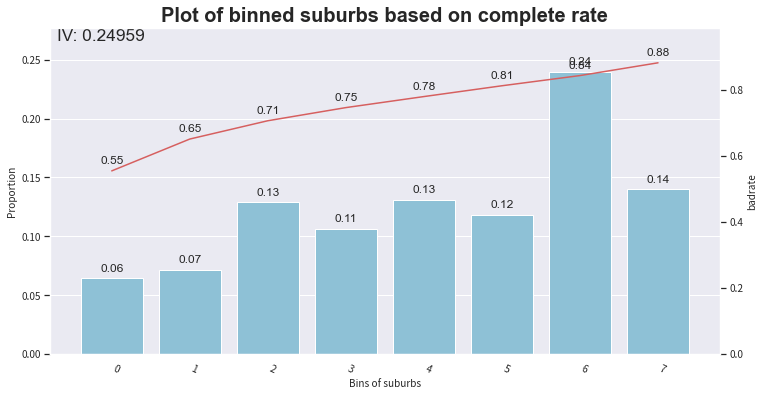

In [29]:
ax = bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')
ax.set_title("Plot of binned suburbs based on complete rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of suburbs")
ax.set_ylabel("Proportion")
#visualize the binning result on training set

Text(0, 0.5, 'Proportion')

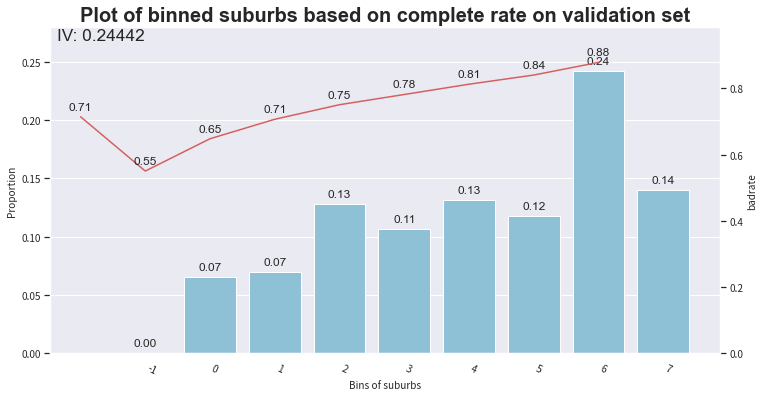

In [16]:
ax = bin_plot(c.transform(validation[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')
ax.set_title("Plot of binned suburbs based on complete rate on validation set",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of suburbs")
ax.set_ylabel("Proportion")
#visualize the binning result on validation set 

In [19]:
data['PuSuburbBins_Completed'] = c.transform(data[['PuSuburb']], labels=False)
validation['PuSuburbBins_Completed'] = c.transform(validation[['PuSuburb']], labels=False)
test['PuSuburbBins_Completed'] = c.transform(test[['PuSuburb']], labels=False)
#build up new feature based on binning on datasets

### Suburb vs. Cancelled

In [28]:
c2 = toad.transform.Combiner()
col = 'PuSuburb'
c2.fit(data[[col,'target_2cls_Cancelled']], y = 'target_2cls_Cancelled', method = 'chi',min_samples = 0.05)  
#use toad package to binning suburbs based on cancelled rate

Text(0, 0.5, 'Proportion')

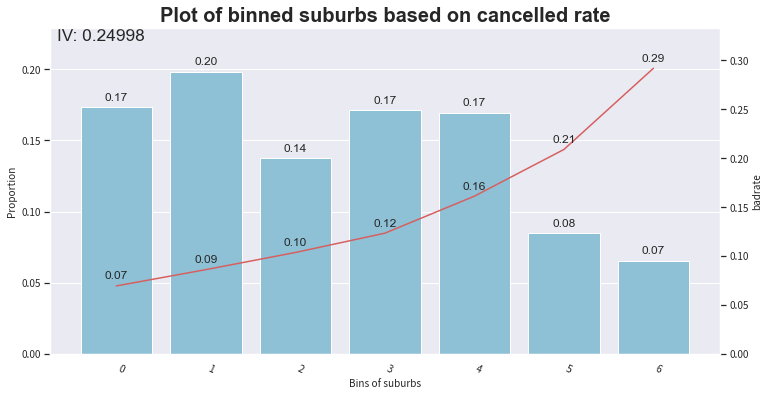

In [30]:
ax = bin_plot(c2.transform(data[[col,'target_2cls_Cancelled']], labels=False), x=col, target='target_2cls_Cancelled')
ax.set_title("Plot of binned suburbs based on cancelled rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of suburbs")
ax.set_ylabel("Proportion")
#visualize the binning result on training set

In [33]:
data['PuSuburbBins_Cancelled'] = c2.transform(data[['PuSuburb']], labels=False)
validation['PuSuburbBins_Cancelled'] = c2.transform(validation[['PuSuburb']], labels=False)
test['PuSuburbBins_Cancelled'] = c2.transform(test[['PuSuburb']], labels=False)
#build up new feature based on binning on datasets

### Suburb vs. Else

In [1]:
c3 = toad.transform.Combiner()
col = 'PuSuburb'
c3.fit(data[[col,'target_2cls_ELSE']], y = 'target_2cls_ELSE', method = 'chi',min_samples = 0.05)  
#use toad package to binning suburbs based on ELSE rate

NameError: name 'toad' is not defined

Text(0, 0.5, 'Proportion')

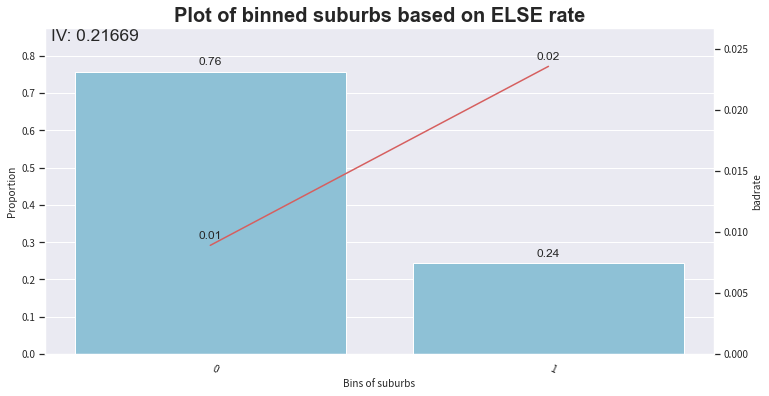

In [35]:
ax = bin_plot(c3.transform(data[[col,'target_2cls_ELSE']], labels=False), x=col, target='target_2cls_ELSE')
ax.set_title("Plot of binned suburbs based on ELSE rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of suburbs")
ax.set_ylabel("Proportion")
#visualize the binning result on training set

In [38]:
data['PuSuburbBins_ELSE'] = c3.transform(data[['PuSuburb']], labels=False)
validation['PuSuburbBins_ELSE'] = c3.transform(validation[['PuSuburb']], labels=False)
test['PuSuburbBins_ELSE'] = c3.transform(test[['PuSuburb']], labels=False)
#build up new feature based on binning on datasets

###  Suburb vs. NoJob

In [39]:
c4 = toad.transform.Combiner()
col = 'PuSuburb'
c4.fit(data[[col,'target_2cls_NoJob']], y = 'target_2cls_NoJob', method = 'chi',min_samples = 0.05)  
#use toad package to binning suburbs based on nojob rate

Text(0, 0.5, 'Proportion')

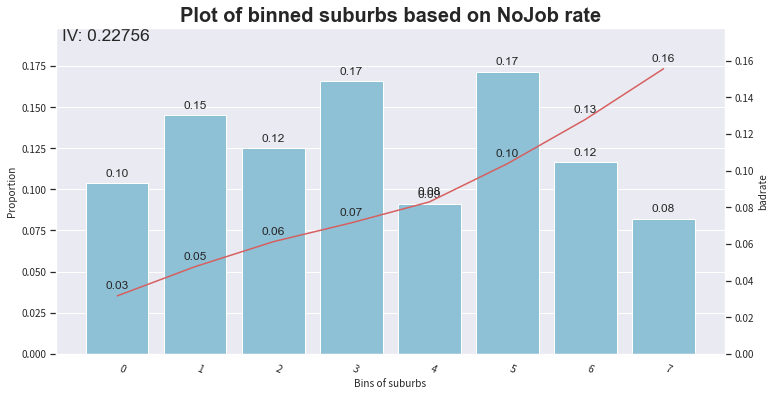

In [40]:
ax = bin_plot(c4.transform(data[[col,'target_2cls_NoJob']], labels=False), x=col, target='target_2cls_NoJob')
ax.set_title("Plot of binned suburbs based on NoJob rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of suburbs")
ax.set_ylabel("Proportion")
#visualize the binning result on training set

In [42]:
data['PuSuburbBins_NoJob'] = c4.transform(data[['PuSuburb']], labels=False)
validation['PuSuburbBins_NoJob'] = c4.transform(validation[['PuSuburb']], labels=False)
test['PuSuburbBins_NoJob'] = c4.transform(test[['PuSuburb']], labels=False)
#build up new feature based on binning on datasets

In [52]:
data[['BookingID','PuSuburb','PuSuburbBins_Cancelled','PuSuburbBins_Completed','PuSuburbBins_ELSE','PuSuburbBins_NoJob']].head()
#binning result in training dataset

,BookingID,PuSuburb,PuSuburbBins_Cancelled,PuSuburbBins_Completed,PuSuburbBins_ELSE,PuSuburbBins_NoJob
0,171970588,Randwick,0,6,0,3
1,174526964,Narraweena,4,3,1,3
2,180286324,Bondi,2,5,0,2
3,177228281,Centennial Park,2,5,0,3
4,170046024,Sydney,6,0,1,6


## Pickup lattitude & longitude

### Lat&Long vs. Complete

In [53]:
knn = KNeighborsClassifier(n_neighbors = 101)

knn.fit(data[['PuLat','PuLong']],data['target_2cls_Completed'])

data['KNN_temp'] = knn.predict_proba(data[['PuLat','PuLong']])[:,1]
#use knn method to model lat and long with target complete and save the probability 

In [54]:
c5 = toad.transform.Combiner()
col = 'KNN_temp'
c5.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)
#use toad package to binning the probabilty to check if it can be used to predict complete 

Text(0, 0.5, 'Proportion')

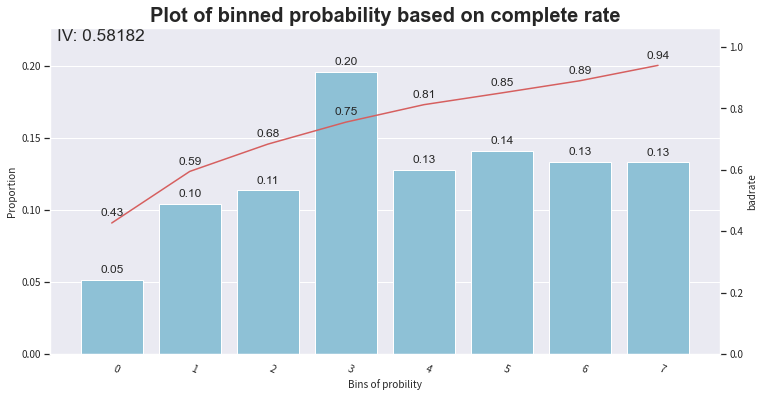

In [56]:
ax=bin_plot(c5.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')
ax.set_title("Plot of binned probability based on complete rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of probility")
ax.set_ylabel("Proportion")
#visualize the binning result to check the iv, the iv is high, thus we can use probability as a feature to predict complete

Text(0, 0.5, 'Proportion')

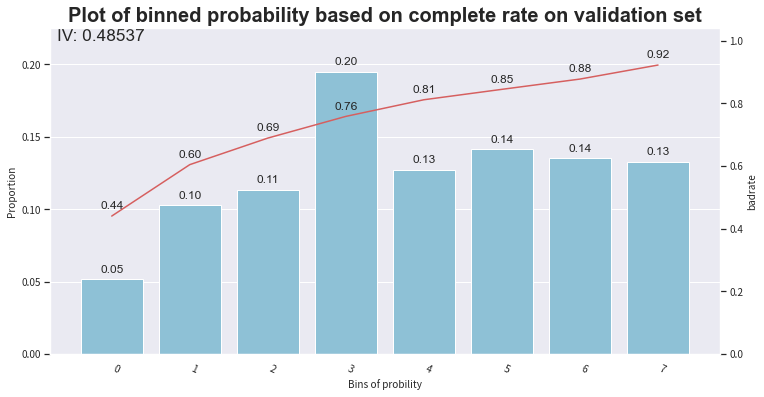

In [57]:
validation['KNN_temp'] = knn.predict_proba(validation[['PuLat','PuLong']])[:,1]
ax=bin_plot(c5.transform(validation[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')
ax.set_title("Plot of binned probability based on complete rate on validation set",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of probility")
ax.set_ylabel("Proportion")
#check on validation set also

In [58]:
data['PuLatLongKNN_Completed'] = knn.predict_proba(data[['PuLat','PuLong']])[:,1]
validation['PuLatLongKNN_Completed'] = knn.predict_proba(validation[['PuLat','PuLong']])[:,1]
test['PuLatLongKNN_Completed'] = knn.predict_proba(test[['PuLat','PuLong']])[:,1]
#apply probability as new feature in datasets 

### Lat&Long Vs. Cancelled

In [62]:
knn2 = KNeighborsClassifier(n_neighbors = 101)

knn2.fit(data[['PuLat','PuLong']],data['target_2cls_Cancelled'])

data['KNN_temp'] = knn2.predict_proba(data[['PuLat','PuLong']])[:,1]
#use knn method to model lat and long with target cancelled and save the probability 

In [63]:
c6 = toad.transform.Combiner()
col = 'KNN_temp'
c6.fit(data[[col,'target_2cls_Cancelled']], y = 'target_2cls_Cancelled', method = 'chi',min_samples = 0.05)
#use toad package to binning the probabilty to check if it can be used to predict cancelled

Text(0, 0.5, 'Proportion')

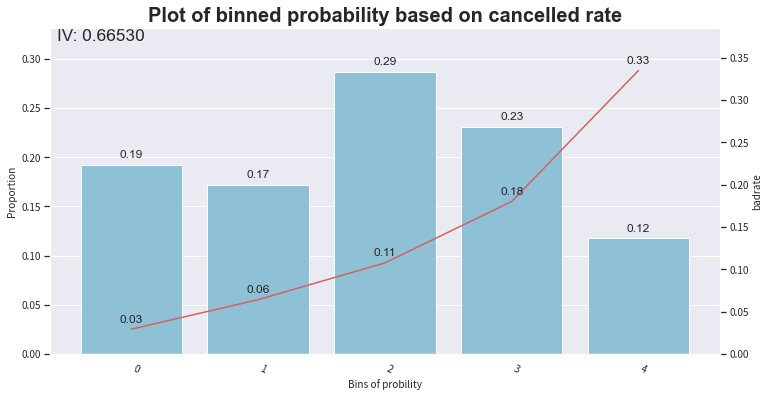

In [64]:
ax=bin_plot(c6.transform(data[[col,'target_2cls_Cancelled']], labels=False), x=col, target='target_2cls_Cancelled')
ax.set_title("Plot of binned probability based on cancelled rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of probility")
ax.set_ylabel("Proportion")
#visualize the binning result to check the iv, the iv is high, thus we can use probability as a feature to predict cancelled

In [65]:
data['PuLatLongKNN_Cancelled'] = knn2.predict_proba(data[['PuLat','PuLong']])[:,1]
validation['PuLatLongKNN_Cancelled'] = knn2.predict_proba(validation[['PuLat','PuLong']])[:,1]
test['PuLatLongKNN_Cancelled'] = knn2.predict_proba(test[['PuLat','PuLong']])[:,1]
#apply probability as new feature in datasets 

### Lat&Long Vs. Else

In [66]:
knn3 = KNeighborsClassifier(n_neighbors = 101)

knn3.fit(data[['PuLat','PuLong']],data['target_2cls_ELSE'])

data['KNN_temp'] = knn3.predict_proba(data[['PuLat','PuLong']])[:,1]
#use knn method to model lat and long with target ELSE and save the probability 

In [67]:
c7 = toad.transform.Combiner()
col = 'KNN_temp'
c7.fit(data[[col,'target_2cls_ELSE']], y = 'target_2cls_ELSE', method = 'chi',min_samples = 0.05)
#use toad package to binning the probabilty to check if it can be used to predict ELSE 

Text(0, 0.5, 'Proportion')

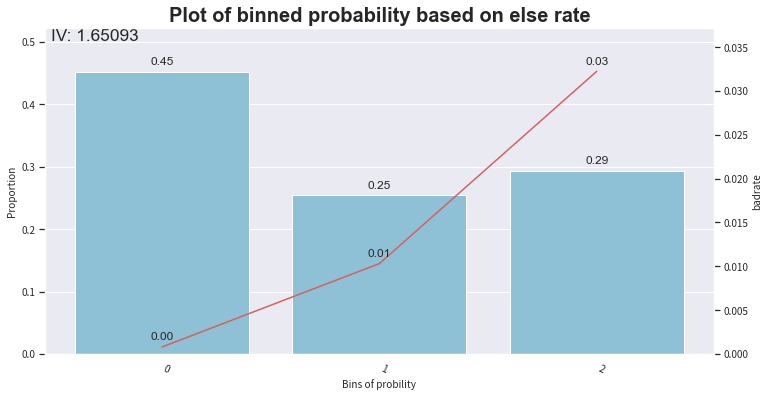

In [68]:
ax=bin_plot(c7.transform(data[[col,'target_2cls_ELSE']], labels=False), x=col, target='target_2cls_ELSE')
ax.set_title("Plot of binned probability based on else rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of probility")
ax.set_ylabel("Proportion")
#visualize the binning result to check the iv, the iv is high, thus we can use probability as a feature to predict else

In [69]:
data['PuLatLongKNN_ELSE'] = knn3.predict_proba(data[['PuLat','PuLong']])[:,1]
validation['PuLatLongKNN_ELSE'] = knn3.predict_proba(validation[['PuLat','PuLong']])[:,1]
test['PuLatLongKNN_ELSE'] = knn3.predict_proba(test[['PuLat','PuLong']])[:,1]
#apply probability as new feature in datasets 

### Lat&Long Vs. Nojob

In [70]:
knn4 = KNeighborsClassifier(n_neighbors = 101)

knn4.fit(data[['PuLat','PuLong']],data['target_2cls_NoJob'])

data['KNN_temp'] = knn4.predict_proba(data[['PuLat','PuLong']])[:,1]
#use knn method to model lat and long with target NOJOB and save the probability 

In [71]:
c8 = toad.transform.Combiner()
col = 'KNN_temp'
c8.fit(data[[col,'target_2cls_NoJob']], y = 'target_2cls_NoJob', method = 'chi',min_samples = 0.05)
#use toad package to binning the probabilty to check if it can be used to predict nojob 

Text(0, 0.5, 'Proportion')

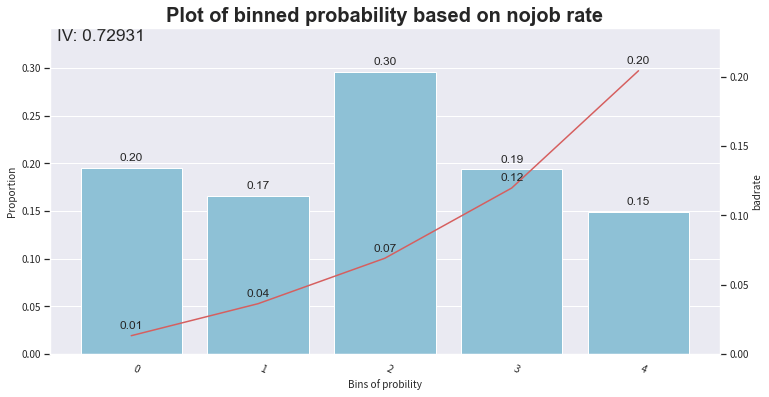

In [72]:
ax=bin_plot(c8.transform(data[[col,'target_2cls_NoJob']], labels=False), x=col, target='target_2cls_NoJob')
ax.set_title("Plot of binned probability based on nojob rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of probility")
ax.set_ylabel("Proportion")
#visualize the binning result to check the iv, the iv is high, thus we can use probability as a feature to predict nojob

In [73]:
data['PuLatLongKNN_NoJob'] = knn4.predict_proba(data[['PuLat','PuLong']])[:,1]
validation['PuLatLongKNN_NoJob'] = knn4.predict_proba(validation[['PuLat','PuLong']])[:,1]
test['PuLatLongKNN_NoJob'] = knn4.predict_proba(test[['PuLat','PuLong']])[:,1]
#apply probability as new feature in datasets 

In [77]:
data[['BookingID','PuLat','PuLong','PuLatLongKNN_Cancelled','PuLatLongKNN_Completed','PuLatLongKNN_ELSE','PuLatLongKNN_NoJob']].head(10)
#new features in training dataset

,BookingID,PuLat,PuLong,PuLatLongKNN_Cancelled,PuLatLongKNN_Completed,PuLatLongKNN_ELSE,PuLatLongKNN_NoJob
0,171970588,-33.921022,151.244202,0.049505,0.930693,0.009901,0.009901
1,174526964,-33.755931,151.273028,0.108911,0.801980,0.009901,0.079208
2,180286324,-33.897201,151.261205,0.089109,0.851485,0.000000,0.059406
3,177228281,-33.895716,151.228609,0.029703,0.930693,0.000000,0.039604
4,170046024,-33.859737,151.213307,0.366337,0.445545,0.029703,0.158416
5,174863088,-33.851305,151.186032,0.168317,0.792079,0.000000,0.039604
6,169960932,-33.839003,151.234135,0.168317,0.782178,0.000000,0.049505
7,171324643,-33.834917,151.210208,0.049505,0.920792,0.009901,0.019802
8,174080542,-33.799541,151.182911,0.069307,0.841584,0.019802,0.069307
9,170182731,-33.805868,151.021825,0.178218,0.712871,0.009901,0.099010


## Time

### Time vs. Complete

In [79]:
def OrderHour(data):
    data = data.copy()
    data['OrderHour'] = data['RequestedDate'].apply(lambda x: x.hour).astype(int)
    return data 
data = OrderHour(data)
validation= OrderHour(validation)
test = OrderHour(test)
#transform hour to numerical data

In [80]:
c9 = toad.transform.Combiner()
col = 'OrderHour'
c9.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)
#use toad to binning hour based on complete rate

Text(0, 0.5, 'Proportion')

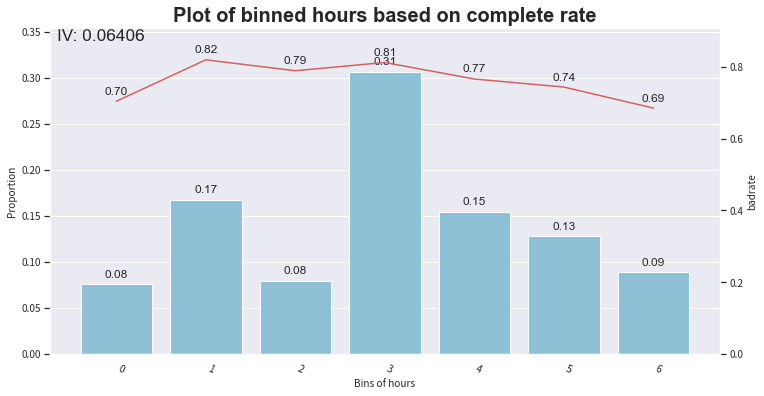

In [82]:
ax=bin_plot(c9.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')
ax.set_title("Plot of binned hours based on complete rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of hours")
ax.set_ylabel("Proportion")
#visualize the binning result, the iv is quite low and the complete rate is not monotonically increasing, so time is not a good feature for predicting complete

In [83]:
def DayOfWeek(data):
    data = data.copy()
    data['DayOfWeek'] = data['RequestedDate'].apply(lambda x: x.weekday()+1)
    return data
data = DayOfWeek(data)
validation = DayOfWeek(validation)
test = DayOfWeek(test)
#transform day of week to numerical data

In [84]:
c10 = toad.transform.Combiner()
col = 'DayOfWeek'
c10.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)
#use toad to binning day of week

Text(0, 0.5, 'Proportion')

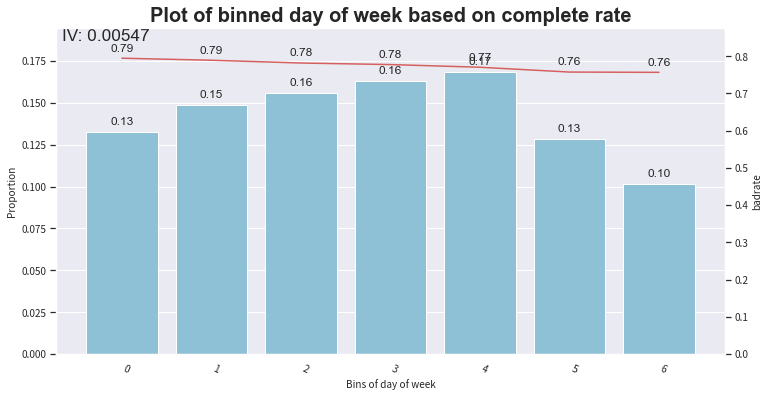

In [85]:
ax=bin_plot(c10.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')
ax.set_title("Plot of binned day of week based on complete rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of day of week")
ax.set_ylabel("Proportion")
#visualize the binning result, the iv is quite low, which means day of week is not a good feature for predicting complete

In [86]:
#try to combine hour and week to see this new feature's ability on predicting target variable
dt = DecisionTreeClassifier(max_depth = 4,min_samples_leaf=0.05)
dt.fit(data[['DayOfWeek','OrderHour']] , data['target_2cls_Completed'])
#use decision tree classifier to model combined dayofweek and hour with target complete 

DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.05)

In [87]:
data['OrderTimeDT_Completed'] = dt.predict_proba(data[['DayOfWeek','OrderHour']])[:,1]
validation['OrderTimeDT_Completed'] = dt.predict_proba(validation[['DayOfWeek','OrderHour']])[:,1]
test['OrderTimeDT_Completed'] = dt.predict_proba(test[['DayOfWeek','OrderHour']])[:,1]
#create new feature using probability on datasets

In [89]:
c11 = toad.transform.Combiner()
col = 'OrderTimeDT_Completed'
c11.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)
#use binning to to check whether ordertime dt is a good feature to predict target complete

Text(0, 0.5, 'Proportion')

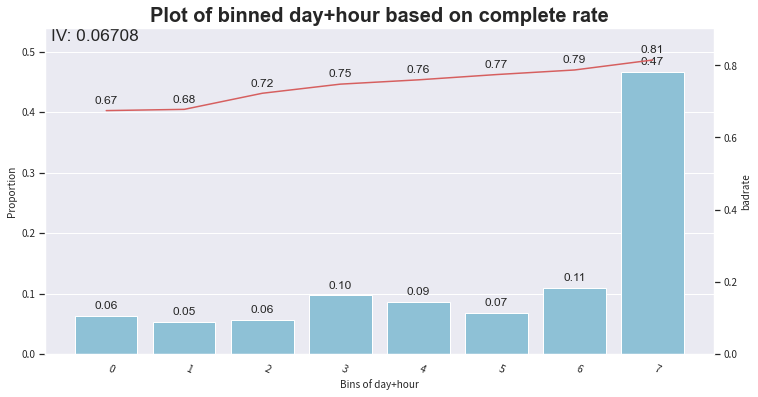

In [90]:
ax=bin_plot(c11.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')
ax.set_title("Plot of binned day+hour based on complete rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of day+hour")
ax.set_ylabel("Proportion")
#visualize the binning result, the iv is okay, so the probability is a reasonably good feature to predict complete

Text(0, 0.5, 'Proportion')

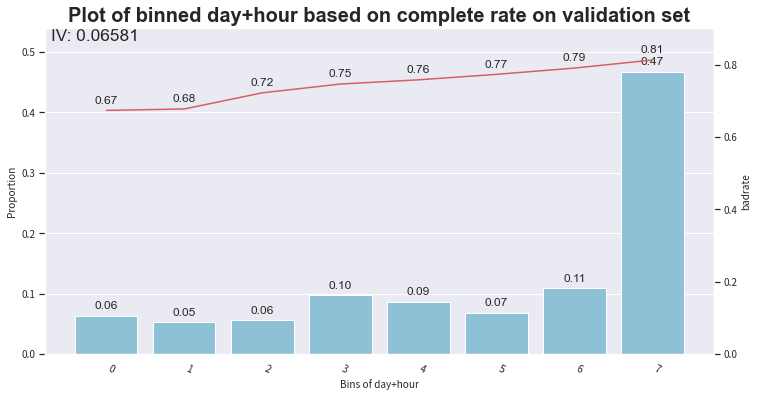

In [96]:
ax=bin_plot(c11.transform(validation[['OrderTimeDT_Completed','target_2cls_Completed']], labels=False), x='OrderTimeDT_Completed', target='target_2cls_Completed')
ax.set_title("Plot of binned day+hour based on complete rate on validation set",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of day+hour")
ax.set_ylabel("Proportion")
#visualize the binning result on validation as well

### Time vs. Cancelled

In [91]:
dt2 = DecisionTreeClassifier(max_depth = 4,min_samples_leaf=0.05)
dt2.fit(data[['DayOfWeek','OrderHour']] , data['target_2cls_Cancelled'])
#use decision tree classifier to model combined hour and day of week with cancelled rate

DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.05)

In [92]:
data['OrderTimeDT_Cancelled'] = dt2.predict_proba(data[['DayOfWeek','OrderHour']])[:,1]
validation['OrderTimeDT_Cancelled'] = dt2.predict_proba(validation[['DayOfWeek','OrderHour']])[:,1]
test['OrderTimeDT_Cancelled'] = dt2.predict_proba(test[['DayOfWeek','OrderHour']])[:,1]
#create new feature using probability on datasets

In [93]:
c12 = toad.transform.Combiner()
col = 'OrderTimeDT_Cancelled'
c12.fit(data[[col,'target_2cls_Cancelled']], y = 'target_2cls_Cancelled', method = 'chi',min_samples = 0.05)
#use binning to to check whether ordertime dt is a good feature to predict target Cancelled

Text(0, 0.5, 'Proportion')

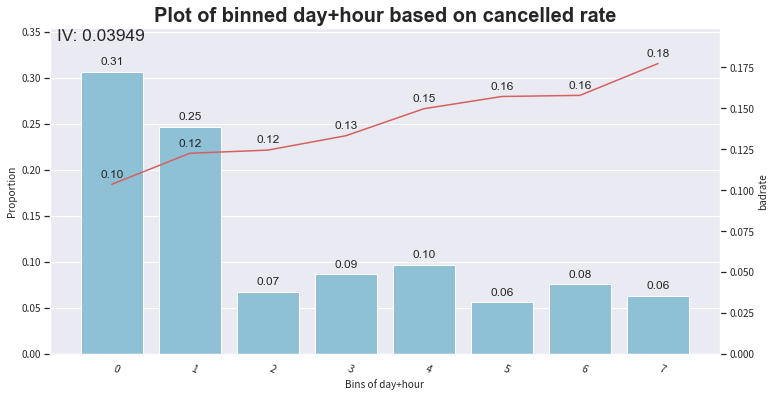

In [98]:
ax=bin_plot(c12.transform(data[['OrderTimeDT_Cancelled','target_2cls_Cancelled']], labels=False), x='OrderTimeDT_Cancelled', target='target_2cls_Cancelled')
ax.set_title("Plot of binned day+hour based on cancelled rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of day+hour")
ax.set_ylabel("Proportion")
#visualize the binning result, the iv is quite low

### Time vs. ELSE

In [106]:
dt3 = DecisionTreeClassifier(max_depth = 4,min_samples_leaf=0.05)
dt3.fit(data[['DayOfWeek','OrderHour']] , data['target_2cls_ELSE'])
#use decision tree classifier to model combined hour and day of week with ELSE rate 

DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.05)

In [107]:
data['OrderTimeDT_ELSE'] = dt3.predict_proba(data[['DayOfWeek','OrderHour']])[:,1]
validation['OrderTimeDT_ELSE'] = dt3.predict_proba(validation[['DayOfWeek','OrderHour']])[:,1]
test['OrderTimeDT_ELSE'] = dt3.predict_proba(test[['DayOfWeek','OrderHour']])[:,1]
#create new feature using probability on datasets

In [108]:
c13 = toad.transform.Combiner()
c13.fit(data[['OrderTimeDT_ELSE','target_2cls_ELSE']], y = 'target_2cls_ELSE', method = 'chi',min_samples = 0.05)
#use binning to to check whether ordertime dt is a good feature to predict target else

Text(0, 0.5, 'Proportion')

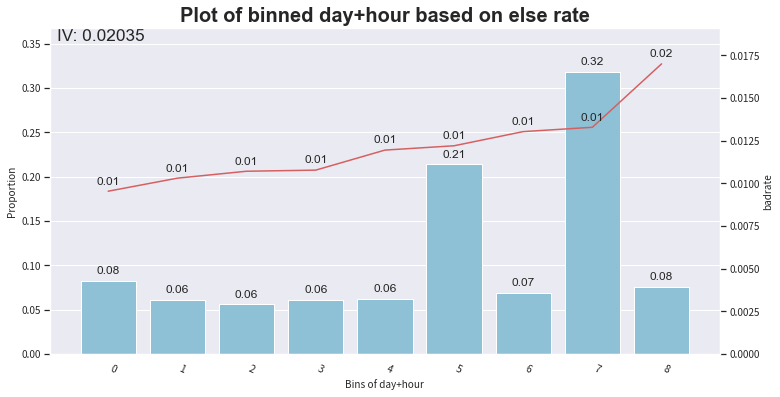

In [109]:
ax=bin_plot(c13.transform(data[['OrderTimeDT_ELSE','target_2cls_ELSE']], labels=False), x='OrderTimeDT_ELSE', target='target_2cls_ELSE')
ax.set_title("Plot of binned day+hour based on else rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of day+hour")
ax.set_ylabel("Proportion")
#visualize the binning result, the iv is quite low

### Time vs. NoJob

In [110]:
dt4 = DecisionTreeClassifier(max_depth = 4,min_samples_leaf=0.05)
dt4.fit(data[['DayOfWeek','OrderHour']] , data['target_2cls_NoJob'])
#use decision tree classifier to model combined hour and day of week with nojob rate

DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.05)

In [111]:
data['OrderTimeDT_NoJob'] = dt4.predict_proba(data[['DayOfWeek','OrderHour']])[:,1]
validation['OrderTimeDT_NoJob'] = dt4.predict_proba(validation[['DayOfWeek','OrderHour']])[:,1]
test['OrderTimeDT_NoJob'] = dt4.predict_proba(test[['DayOfWeek','OrderHour']])[:,1]
#create new feature using probability on datasets

In [113]:
c14 = toad.transform.Combiner()
c14.fit(data[['OrderTimeDT_NoJob','target_2cls_NoJob']], y = 'target_2cls_NoJob', method = 'chi',min_samples = 0.05)
#use binning to to check whether ordertime dt is a good feature to predict target else

Text(0, 0.5, 'Proportion')

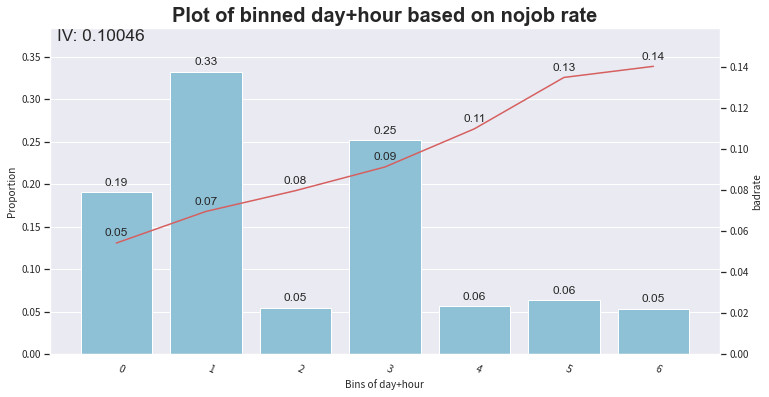

In [114]:
ax=bin_plot(c14.transform(data[['OrderTimeDT_NoJob','target_2cls_NoJob']], labels=False), x='OrderTimeDT_NoJob', target='target_2cls_NoJob')
ax.set_title("Plot of binned day+hour based on nojob rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of day+hour")
ax.set_ylabel("Proportion")
#visualize the binning result, the iv is high, it is a good feature to predict nojob

In [115]:
data[['BookingID','OrderHour','DayOfWeek','OrderTimeDT_Cancelled','OrderTimeDT_Completed','OrderTimeDT_ELSE','OrderTimeDT_NoJob']].head()
#visualize engineered hour and dayofweek in training dataset

,BookingID,OrderHour,DayOfWeek,OrderTimeDT_Cancelled,OrderTimeDT_Completed,OrderTimeDT_ELSE,OrderTimeDT_NoJob
0,171970588,11,4,0.103625,0.814538,0.013291,0.069492
1,174526964,9,7,0.103625,0.786954,0.012206,0.069492
2,180286324,0,7,0.157953,0.677855,0.017008,0.140237
3,177228281,9,4,0.103625,0.814538,0.012206,0.069492
4,170046024,21,4,0.177400,0.674436,0.013037,0.134820


## Conditions

### Conditions vs. Complete

In [125]:
data['Conditions'] = data['Conditions'].astype(str)
validation['Conditions'] = validation['Conditions'].astype(str)
c15 = toad.transform.Combiner()
c15.fit(data[['Conditions','target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)
#use toad to bin the conditions based on complete rate

In [126]:
c15.export()
#binning result

{'Conditions': [['4299161600',
   '138412032',
   '272629760',
   '137439215616',
   '274877916238',
   '4294983680',
   '554054975488',
   '275951648800',
   '274877906946',
   '274894684160',
   '275414777856',
   '17213423616',
   '554050781186',
   '17448304640',
   '17314086912',
   '17179869184',
   '12',
   '4299161604',
   '10',
   '549827117056',
   '68157440',
   '1048640',
   '16777248',
   '274877906948',
   '4456448',
   '4194306',
   '134234112',
   '138412036',
   '4194312',
   '103079215104',
   '274877908040',
   '279172874240',
   '134218752',
   '550028443648',
   '17183014912',
   '134217734',
   '32768',
   '549894225920',
   '274878955520',
   '536887296',
   '268435520',
   '824633720834',
   '4195330',
   '824633720832',
   '1572864',
   '554050781184',
   '549793562624',
   '34359738368',
   '275012124672',
   '134217792',
   '34359738432',
   '32',
   '274877906976',
   '20971520',
   '549890031616',
   '16386',
   '67108872',
   '268435456',
   '37748736',
  

Text(0, 0.5, 'Proportion')

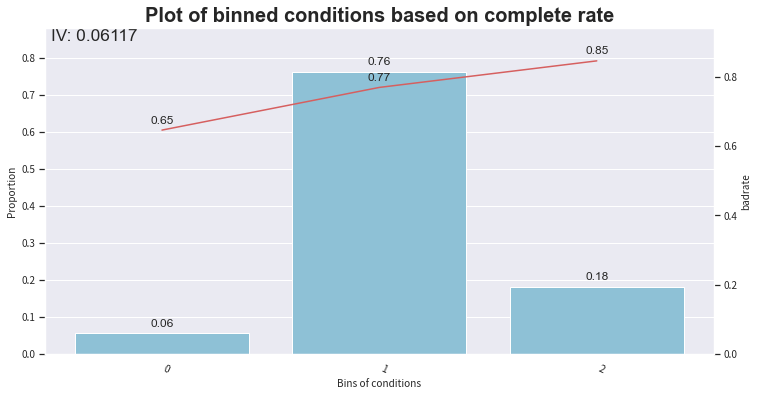

In [127]:
ax=bin_plot(c15.transform(data[['Conditions','target_2cls_Completed']], labels=False), x='Conditions', target='target_2cls_Completed')
ax.set_title("Plot of binned conditions based on complete rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize binning result, the iv is okay, so the binned conditions is a good feature for predicting complete

Text(0, 0.5, 'Proportion')

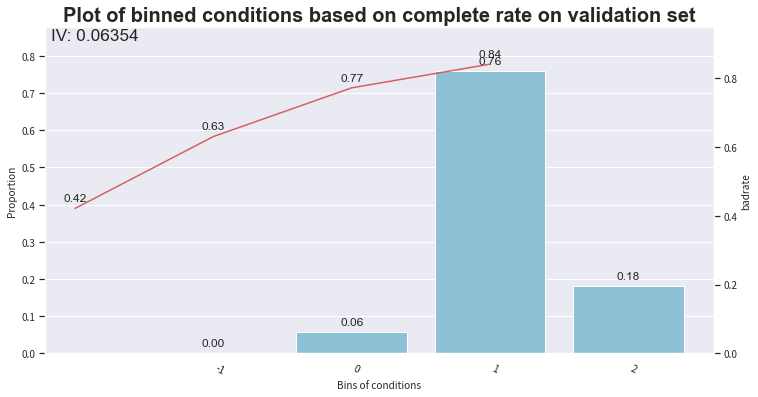

In [128]:
ax=bin_plot(c15.transform(validation[['Conditions','target_2cls_Completed']], labels=False), x='Conditions', target='target_2cls_Completed')
ax.set_title("Plot of binned conditions based on complete rate on validation set",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize binning result on validation set and check iv

In [133]:
test['Conditions'] = test['Conditions'].astype(str)

In [134]:
data['ConditionsBins_Completed'] = c15.transform(data[['Conditions']], labels=False)
validation['ConditionsBins_Completed'] = c15.transform(validation[['Conditions']], labels=False)
test['ConditionsBins_Completed'] = c15.transform(test[['Conditions']], labels=False)
#create new feature based on binning on datasets

### Conditions vs Cancelled

In [136]:
c16 = toad.transform.Combiner()
c16.fit(data[['Conditions','target_2cls_Cancelled']], y = 'target_2cls_Cancelled', method = 'chi',min_samples = 0.05)
#use toad to bin the conditions based on cancelled rate

In [137]:
c16.export()
#binning result

{'Conditions': [['4325376',
   '131136',
   '68',
   '274877915136',
   '68719476800',
   '20971524',
   '64',
   '274877906976',
   '131072',
   '1032',
   '536870914',
   '137438953536',
   '8192',
   '24576',
   '274882101248',
   '16384',
   '8589934592',
   '536870916',
   '412316860416',
   '524292',
   '67125248',
   '549755830272',
   '4202496',
   '33554436',
   '17246978050',
   '393216',
   '275418972160',
   '137438953472',
   '1028',
   '262144',
   '274878038016',
   '68719476740',
   '16908288',
   '274882117632',
   '549755830336',
   '67108868',
   '1026',
   '524288',
   '16448',
   '4210688',
   '274877923328',
   '17196646400',
   '17180917760',
   '4194304',
   '33554434',
   '274877907008',
   '278528',
   '16777220',
   '67108866',
   '274877906944',
   '532480',
   '1179648',
   '0'],
  ['16777280',
   '4195328',
   '16777218',
   '16793600',
   '549755813888',
   '540672',
   '786432',
   '549789368322',
   '4195330',
   '412316860480',
   '274882101312',
   '1

Text(0, 0.5, 'Proportion')

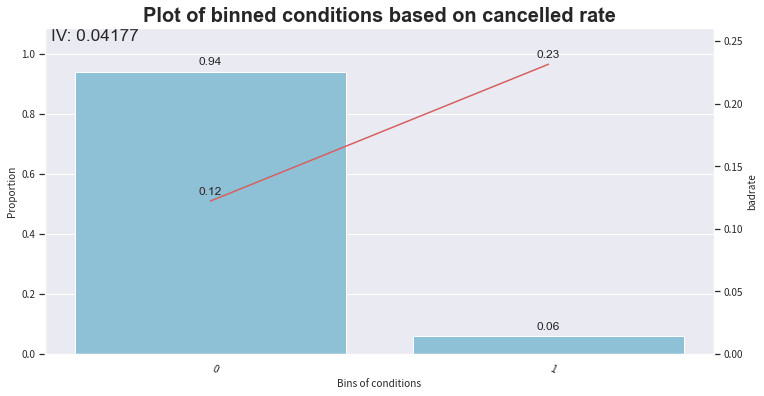

In [138]:
ax=bin_plot(c16.transform(data[['Conditions','target_2cls_Cancelled']], labels=False), x='Conditions', target='target_2cls_Cancelled')
ax.set_title("Plot of binned conditions based on cancelled rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize binning result, the iv is quite low, however we need to check for other targets

In [139]:
data['ConditionsBins_Cancelled'] = c16.transform(data[['Conditions']], labels=False)
validation['ConditionsBins_Cancelled'] = c16.transform(validation[['Conditions']], labels=False)
test['ConditionsBins_Cancelled'] = c16.transform(test[['Conditions']], labels=False)
#create new feature based on binning on datasets

### Conditions vs. ELSE

In [140]:
c17 = toad.transform.Combiner()
c17.fit(data[['Conditions','target_2cls_ELSE']], y = 'target_2cls_ELSE', method = 'chi',min_samples = 0.05)
#use toad to bin the conditions based on else rate

In [141]:
c17.export()
#binning result

{'Conditions': [['4325376',
   '0',
   '137438953472',
   '68719476736',
   '343597383680',
   '4194304'],
  ['274882101248',
   '4194368',
   '278528',
   '412316860416',
   '131136',
   '540672',
   '137438953536',
   '274877906944',
   '68719476800',
   '206158430208',
   '8589934592',
   '64',
   '16384',
   '16777216',
   '8192',
   '268435456',
   '1310720',
   '549822922752',
   '4202496',
   '131072',
   '33554432',
   '824633720832',
   '16448',
   '550292684800',
   '1024',
   '16777280',
   '549772591108',
   '67108864',
   '541065216',
   '262144',
   '17180917760',
   '549755813888',
   '274877907008',
   '1064960',
   '274877915136',
   '24576',
   '274877923328',
   '481036337152',
   '549772591104',
   '275414777856',
   '274877907968',
   '132096',
   '524288',
   '16777220',
   '16793600',
   '4210688',
   '268435458',
   '549789368324',
   '393216',
   '275418972160',
   '536870912',
   '1088',
   '1048576',
   '549890031616',
   '1048580',
   '262146',
   '16777224'

Text(0, 0.5, 'Proportion')

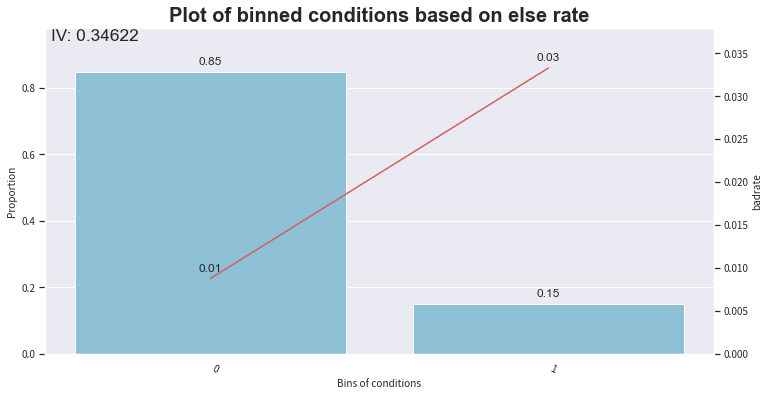

In [142]:
ax=bin_plot(c17.transform(data[['Conditions','target_2cls_ELSE']], labels=False), x='Conditions', target='target_2cls_ELSE')
ax.set_title("Plot of binned conditions based on else rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize binning result, the iv is high, thus the binned conditions is a good feature for predicting else

In [143]:
data['ConditionsBins_ELSE'] = c17.transform(data[['Conditions']], labels=False)
validation['ConditionsBins_ELSE'] = c17.transform(validation[['Conditions']], labels=False)
test['ConditionsBins_ELSE'] = c17.transform(test[['Conditions']], labels=False)
#create new feature based on binning on datasets

### Conditions vs. NoJob

In [144]:
c18 = toad.transform.Combiner()
c18.fit(data[['Conditions','target_2cls_NoJob']], y = 'target_2cls_NoJob', method = 'chi',min_samples = 0.05)
#use toad to bin the conditions based on else rate

In [145]:
c18.export()
#binning result

{'Conditions': [['274882101312',
   '137438953472',
   '64',
   '68719476736',
   '343597383680',
   '16448',
   '412316860416',
   '3145728',
   '1310720',
   '541065216',
   '274877907008',
   '34359738368',
   '206158430208',
   '1048576',
   '4194368',
   '1088',
   '262144',
   '524288',
   '4456448',
   '131136',
   '540672',
   '17180917760',
   '137438953536',
   '278528',
   '1064960',
   '68719476800',
   '20971520',
   '262208',
   '138412032',
   '8589934592',
   '550292684800',
   '37748736',
   '2621440',
   '268435460',
   '270336',
   '2097152',
   '786432',
   '17180131328',
   '4194306',
   '16777280',
   '71303168',
   '272629760',
   '8256',
   '4195328',
   '68',
   '4210688',
   '262148',
   '4325376',
   '274877906948',
   '481036337152'],
  ['4194304'],
  ['16793600',
   '275414777856',
   '536870916',
   '274882101248',
   '67108866',
   '393216',
   '4194308',
   '1048640',
   '275418972160',
   '16785408',
   '17180393472',
   '1048580',
   '4299161600',
   '

Text(0, 0.5, 'Proportion')

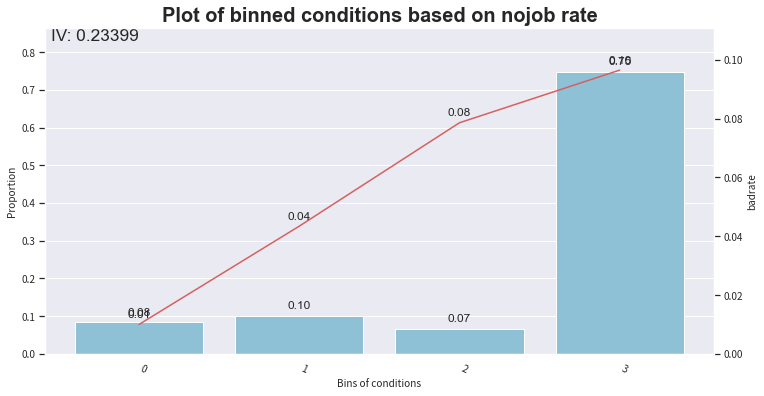

In [146]:
ax=bin_plot(c18.transform(data[['Conditions','target_2cls_NoJob']], labels=False), x='Conditions', target='target_2cls_NoJob')
ax.set_title("Plot of binned conditions based on nojob rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize binning result, the iv is high, thus the binned conditions is a good feature for predicting nojob

In [147]:
data['ConditionsBins_NoJob'] = c18.transform(data[['Conditions']], labels=False)
validation['ConditionsBins_NoJob'] = c18.transform(validation[['Conditions']], labels=False)
test['ConditionsBins_NoJob'] = c18.transform(test[['Conditions']], labels=False)
#create new feature based on binning on datasets

In [148]:
data[['BookingID','Conditions','ConditionsBins_Cancelled','ConditionsBins_Completed','ConditionsBins_ELSE','ConditionsBins_NoJob']].head(20)
#visualize engineered conditions in training dataset

,BookingID,Conditions,ConditionsBins_Cancelled,ConditionsBins_Completed,ConditionsBins_ELSE,ConditionsBins_NoJob
0,171970588,0,0,1,0,3
1,174526964,0,0,1,0,3
2,180286324,0,0,1,0,3
3,177228281,0,0,1,0,3
4,170046024,0,0,1,0,3
5,174863088,0,0,1,0,3
6,169960932,0,0,1,0,3
7,171324643,0,0,1,0,3
8,174080542,524288,0,2,1,0
9,170182731,0,0,1,0,3


## Booking Fleet = Dispatch Fleet

In [149]:
equal = list()
for i in range(data.shape[0]):
    if data['BookingFleet'][i] == data['DispatchFleet'][i]:
        equal.append('True')
    else:
        equal.append('False')
#check whether booking fleet is the same as dispatch feet and create a new variable

In [150]:
equal2 = list()
for i in range(validation.shape[0]):
    if validation['BookingFleet'][i] == validation['DispatchFleet'][i]:
        equal2.append('True')
    else:
        equal2.append('False')
#same for validation set

In [215]:
equal3 = list()
for i in range(test.shape[0]):
    if test['BookingFleet'][i] == test['DispatchFleet'][i]:
        equal3.append('True')
    else:
        equal3.append('False')
#same for test set

In [151]:
data['BookingisDispatch'] = equal
validation['BookingisDispatch'] = equal2
#create new boolean variable 

In [216]:
test['BookingisDispatch'] = equal3

## Dispatch Fleet

### Dispatch Fleet vs. Completed

In [152]:
c19 = toad.transform.Combiner()
c19.fit(data[['DispatchFleet','target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.01)
#use toad to bin dispatch fleet based on complete rate

In [153]:
c19.export()
#binning result

{'DispatchFleet': [['Training Sydney',
   'South Western Cabs',
   'iHail',
   'Sydney Tiger Team',
   '13cabs Wollongong',
   'WATs Sydney',
   'Blue Mountains 13cabs'],
  ['13cabs Sydney', 'Test Sydney'],
  ['Silver Service Sydney']]}

Text(0, 0.5, 'Proportion')

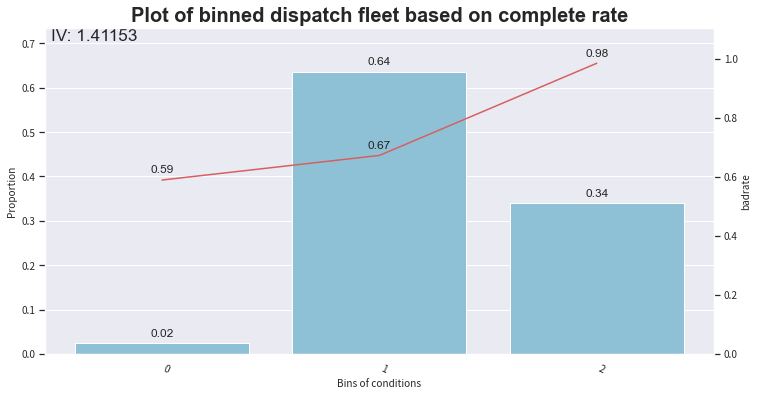

In [154]:
ax=bin_plot(c19.transform(data[['DispatchFleet','target_2cls_Completed']], labels=False), x='DispatchFleet', target='target_2cls_Completed')
ax.set_title("Plot of binned dispatch fleet based on complete rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize the binning result, the iv is quite high, binned dispatch fleet is a good feature for predicting complete

Text(0, 0.5, 'Proportion')

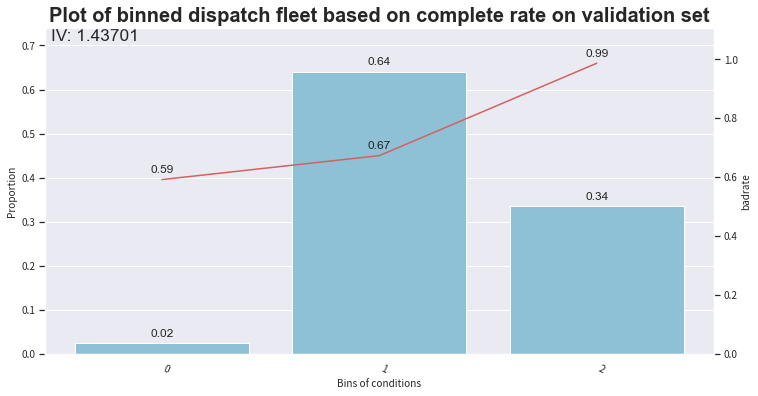

In [155]:
ax=bin_plot(c19.transform(validation[['DispatchFleet','target_2cls_Completed']], labels=False), x='DispatchFleet', target='target_2cls_Completed')
ax.set_title("Plot of binned dispatch fleet based on complete rate on validation set",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize on validation set also

In [156]:
data['DispatchFleetBins_Completed'] = c19.transform(data[['DispatchFleet']], labels=False) 
validation['DispatchFleetBins_Completed'] = c19.transform(validation[['DispatchFleet']], labels=False) 
test['DispatchFleetBins_Completed'] = c19.transform(test[['DispatchFleet']], labels=False)
#create new features based on binning

### Dispatch Fleet vs. Cancelled

In [157]:
c20 = toad.transform.Combiner()
c20.fit(data[['DispatchFleet','target_2cls_Cancelled']], y = 'target_2cls_Cancelled', method = 'chi',min_samples = 0.01)
#use toad to bin dispatch fleet based on cancelled rate

In [158]:
c20.export()
#binning result

{'DispatchFleet': [['Silver Service Sydney'],
  ['iHail', '13cabs Sydney'],
  ['Test Sydney',
   'Training Sydney',
   'Blue Mountains 13cabs',
   'South Western Cabs',
   'WATs Sydney',
   'Sydney Tiger Team',
   '13cabs Wollongong']]}

Text(0, 0.5, 'Proportion')

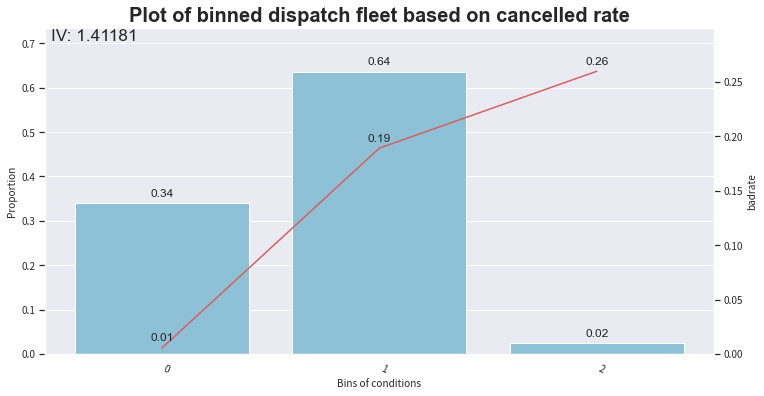

In [160]:
ax=bin_plot(c20.transform(data[['DispatchFleet','target_2cls_Cancelled']], labels=False), x='DispatchFleet', target='target_2cls_Cancelled')
ax.set_title("Plot of binned dispatch fleet based on cancelled rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize the binning result, the iv is quite high, binned dispatch fleet is a good feature for predicting Cancelled

In [161]:
data['DispatchFleetBins_Cancelled'] = c20.transform(data[['DispatchFleet']], labels=False) 
validation['DispatchFleetBins_Cancelled'] = c20.transform(validation[['DispatchFleet']], labels=False) 
test['DispatchFleetBins_Cancelled'] = c20.transform(test[['DispatchFleet']], labels=False)
#create new features based on binning

### Dispatch Fleet vs. ELSE

In [162]:
c21 = toad.transform.Combiner()
c21.fit(data[['DispatchFleet','target_2cls_ELSE']], y = 'target_2cls_ELSE', method = 'chi',min_samples = 0.01)
#use toad to bin dispatch fleet based on else rate

In [163]:
c21.export()

{'DispatchFleet': [['Silver Service Sydney'],
  ['13cabs Sydney'],
  ['Test Sydney',
   'Sydney Tiger Team',
   'Blue Mountains 13cabs',
   'WATs Sydney',
   'South Western Cabs',
   '13cabs Wollongong',
   'iHail',
   'Training Sydney']]}

Text(0, 0.5, 'Proportion')

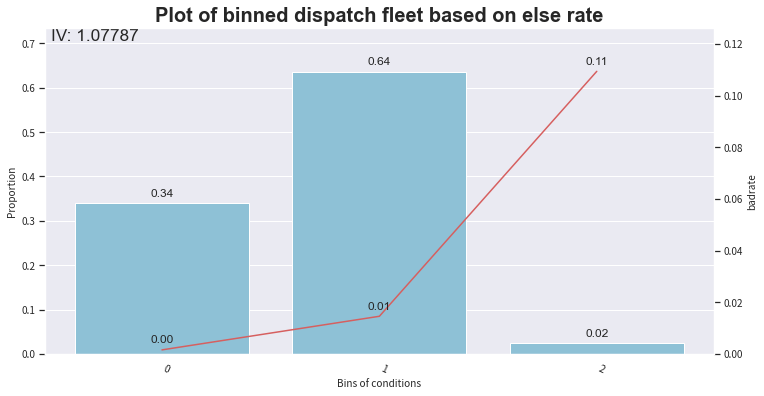

In [164]:
ax=bin_plot(c21.transform(data[['DispatchFleet','target_2cls_ELSE']], labels=False), x='DispatchFleet', target='target_2cls_ELSE')
ax.set_title("Plot of binned dispatch fleet based on else rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize the binning result, the iv is quite high, binned dispatch fleet is a good feature for predicting ELSE

In [165]:
data['DispatchFleetBins_ELSE'] = c21.transform(data[['DispatchFleet']], labels=False) 
validation['DispatchFleetBins_ELSE'] = c21.transform(validation[['DispatchFleet']], labels=False) 
test['DispatchFleetBins_ELSE'] = c21.transform(test[['DispatchFleet']], labels=False)
#create new features based on binning

### Dispatch Fleet vs. NoJob

In [166]:
c22 = toad.transform.Combiner()
c22.fit(data[['DispatchFleet','target_2cls_NoJob']], y = 'target_2cls_NoJob', method = 'chi',min_samples = 0.01)
#use toad to bin dispatch fleet based on NoJob rate

In [167]:
c22.export()

{'DispatchFleet': [['Training Sydney', 'Test Sydney', 'Silver Service Sydney'],
  ['WATs Sydney', 'Blue Mountains 13cabs', 'Sydney Tiger Team'],
  ['13cabs Sydney', 'iHail', '13cabs Wollongong', 'South Western Cabs']]}

Text(0, 0.5, 'Proportion')

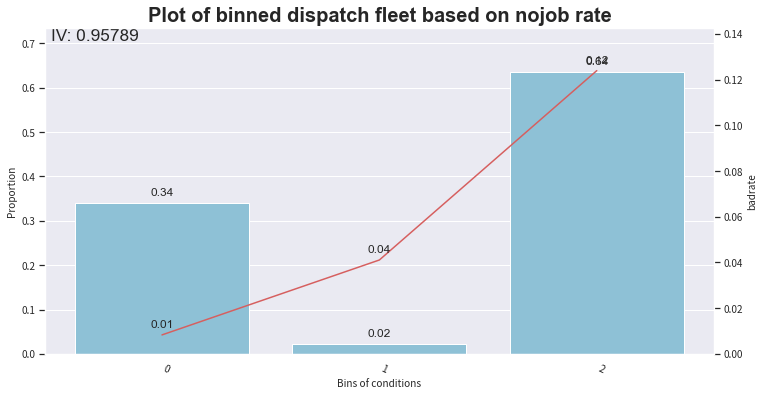

In [168]:
ax=bin_plot(c22.transform(data[['DispatchFleet','target_2cls_NoJob']], labels=False), x='DispatchFleet', target='target_2cls_NoJob')
ax.set_title("Plot of binned dispatch fleet based on nojob rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize the binning result, the iv is quite high, binned dispatch fleet is a good feature for predicting NoJob

In [169]:
data['DispatchFleetBins_NoJob'] = c22.transform(data[['DispatchFleet']], labels=False) 
validation['DispatchFleetBins_NoJob'] = c22.transform(validation[['DispatchFleet']], labels=False) 
test['DispatchFleetBins_NoJob'] = c22.transform(test[['DispatchFleet']], labels=False)
#create new features based on binning

In [170]:
data[['BookingID','DispatchFleet','DispatchFleetBins_Cancelled','DispatchFleetBins_Completed','DispatchFleetBins_ELSE','DispatchFleetBins_NoJob']].head(10)

,BookingID,DispatchFleet,DispatchFleetBins_Cancelled,DispatchFleetBins_Completed,DispatchFleetBins_ELSE,DispatchFleetBins_NoJob
0,171970588,13cabs Sydney,1,1,1,2
1,174526964,13cabs Sydney,1,1,1,2
2,180286324,13cabs Sydney,1,1,1,2
3,177228281,13cabs Sydney,1,1,1,2
4,170046024,13cabs Sydney,1,1,1,2
5,174863088,13cabs Sydney,1,1,1,2
6,169960932,Silver Service Sydney,0,2,0,0
7,171324643,Silver Service Sydney,0,2,0,0
8,174080542,13cabs Sydney,1,1,1,2
9,170182731,Silver Service Sydney,0,2,0,0


## Booking Fleet

### Booking Fleet vs. Complete

In [171]:
data[['BookingFleet','target_2cls_Completed']].groupby('BookingFleet').agg(['mean','count']).\
sort_values(by=('target_2cls_Completed','mean'),ascending=True)

target_2cls_Completed         
                                       mean    count
BookingFleet                                        
Training Sydney                    0.002483     2416
iHail                              0.394737      304
Sydney Tiger Team                  0.466667       15
Blue Mountains 13cabs              0.654786    21352
Test Sydney                        0.708333       96
South Western Cabs                 0.719902      814
13cabs Sydney                      0.772805  2766068
WATs Sydney                        0.832917   118037
Silver Service Sydney              0.860334    90881
13cabs Wollongong                  0.941176       17

In [172]:
c23 = toad.transform.Combiner()
c23.fit(data[['BookingFleet','target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.001)
#use toad to bin booking fleet based on complete rate

In [173]:
c23.export()#binning result

{'BookingFleet': [['Training Sydney',
   'iHail',
   'Sydney Tiger Team',
   'Blue Mountains 13cabs',
   'Test Sydney',
   'South Western Cabs'],
  ['13cabs Sydney'],
  ['WATs Sydney', 'Silver Service Sydney', '13cabs Wollongong']]}

Text(0, 0.5, 'Proportion')

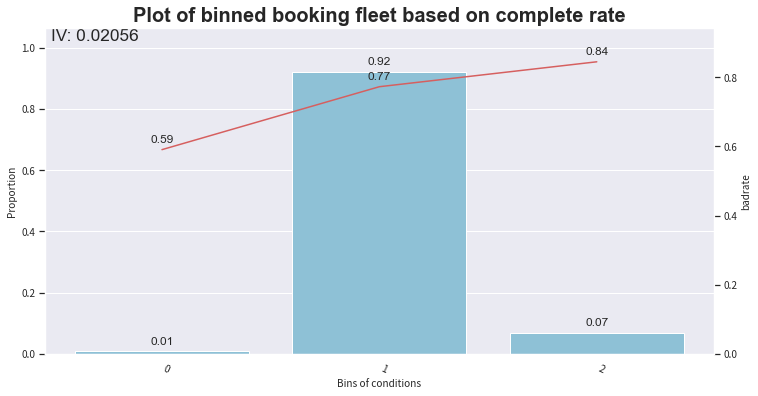

In [174]:
ax=bin_plot(c23.transform(data[['BookingFleet','target_2cls_Completed']], labels=False), x='BookingFleet', target='target_2cls_Completed')
ax.set_title("Plot of binned booking fleet based on complete rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize the binning result and check for iv

Text(0, 0.5, 'Proportion')

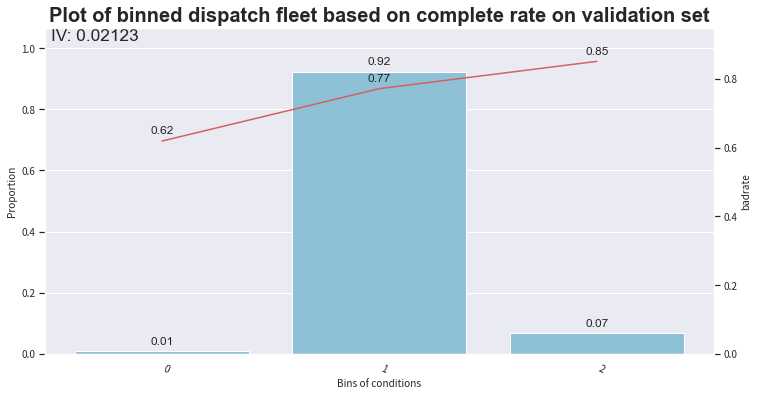

In [175]:
ax=bin_plot(c23.transform(validation[['BookingFleet','target_2cls_Completed']], labels=False), x='BookingFleet', target='target_2cls_Completed')
ax.set_title("Plot of binned dispatch fleet based on complete rate on validation set",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize the binning result on validation set and check for iv

In [176]:
#the iv is quite low which means booking fleet is not a good feature for predicting complete, however we need to 
#check for other target

In [177]:
data['BookingFleetBins_Completed'] = c23.transform(data[['BookingFleet']], labels=False) 
validation['BookingFleetBins_Completed'] = c23.transform(validation[['BookingFleet']], labels=False) 
test['BookingFleetBins_Completed'] = c23.transform(test[['BookingFleet']], labels=False)



### Booking Fleet vs. Cancelled

In [178]:
c24 = toad.transform.Combiner()
c24.fit(data[['BookingFleet','target_2cls_Cancelled']], y = 'target_2cls_Cancelled', method = 'chi',min_samples = 0.001)
#use toad to bin booking fleet based on cancelled rate

In [179]:
c24.export()

{'BookingFleet': [['Silver Service Sydney',
   '13cabs Wollongong',
   'iHail',
   'South Western Cabs'],
  ['WATs Sydney'],
  ['13cabs Sydney'],
  ['Training Sydney',
   'Blue Mountains 13cabs',
   'Test Sydney',
   'Sydney Tiger Team']]}

Text(0, 0.5, 'Proportion')

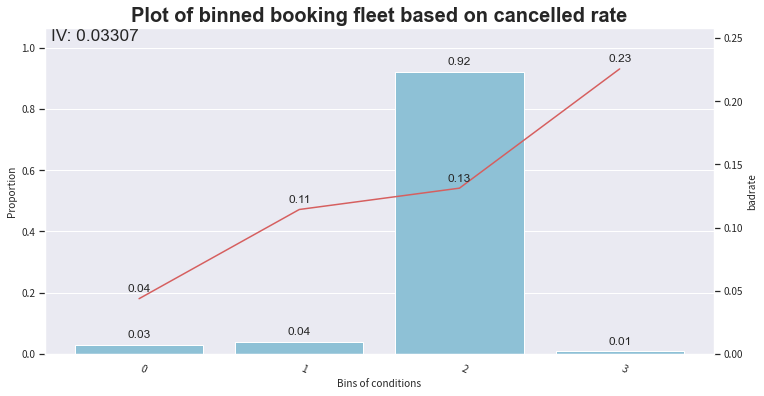

In [180]:
ax=bin_plot(c24.transform(data[['BookingFleet','target_2cls_Cancelled']], labels=False), x='BookingFleet', target='target_2cls_Cancelled')
ax.set_title("Plot of binned booking fleet based on cancelled rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize the binning result and check for iv

In [181]:
data['BookingFleetBins_Cancelled'] = c24.transform(data[['BookingFleet']], labels=False) 
validation['BookingFleetBins_Cancelled'] = c24.transform(validation[['BookingFleet']], labels=False) 
test['BookingFleetBins_Cancelled'] = c24.transform(test[['BookingFleet']], labels=False)


### Booking Fleet vs. ELSE

In [184]:
c25 = toad.transform.Combiner()
c25.fit(data[['BookingFleet','target_2cls_ELSE']], y = 'target_2cls_ELSE', method = 'chi',min_samples = 0.001)
#use toad to bin booking fleet based on ELSE rate

In [185]:
c25.export()

{'BookingFleet': [['13cabs Sydney'],
  ['Silver Service Sydney',
   'South Western Cabs',
   'Test Sydney',
   'WATs Sydney',
   '13cabs Wollongong',
   'Sydney Tiger Team',
   'Blue Mountains 13cabs',
   'iHail',
   'Training Sydney']]}

Text(0, 0.5, 'Proportion')

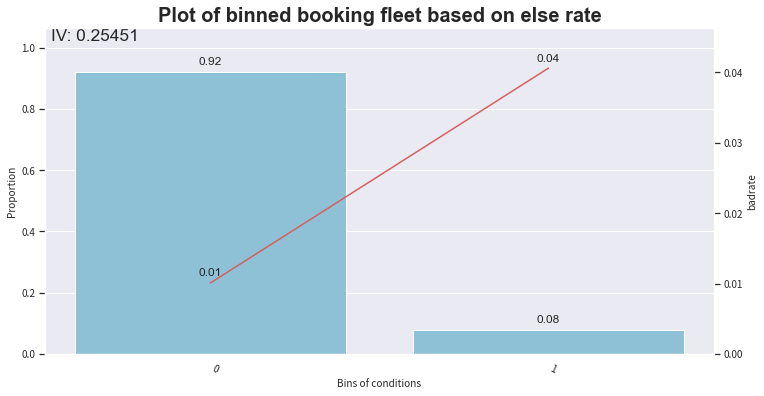

In [186]:
ax=bin_plot(c25.transform(data[['BookingFleet','target_2cls_ELSE']], labels=False), x='BookingFleet', target='target_2cls_ELSE')
ax.set_title("Plot of binned booking fleet based on else rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize the binning result and check for iv
#iv is quite high, binned booking fleet is a good feature for predicting else

In [187]:
data['BookingFleetBins_ELSE'] = c25.transform(data[['BookingFleet']], labels=False) 
validation['BookingFleetBins_ELSE'] = c25.transform(validation[['BookingFleet']], labels=False) 
test['BookingFleetBins_ELSE'] = c25.transform(test[['BookingFleet']], labels=False)


### Booking Fleet vs. NoJob

In [188]:
c26 = toad.transform.Combiner()
c26.fit(data[['BookingFleet','target_2cls_NoJob']], y = 'target_2cls_NoJob', method = 'chi',min_samples = 0.001)
#use toad to bin booking fleet based on NoJob rate

In [189]:
c26.export()

{'BookingFleet': [['Training Sydney', 'Test Sydney', 'WATs Sydney'],
  ['Blue Mountains 13cabs',
   '13cabs Wollongong',
   'Sydney Tiger Team',
   'iHail',
   'Silver Service Sydney'],
  ['13cabs Sydney', 'South Western Cabs']]}

Text(0, 0.5, 'Proportion')

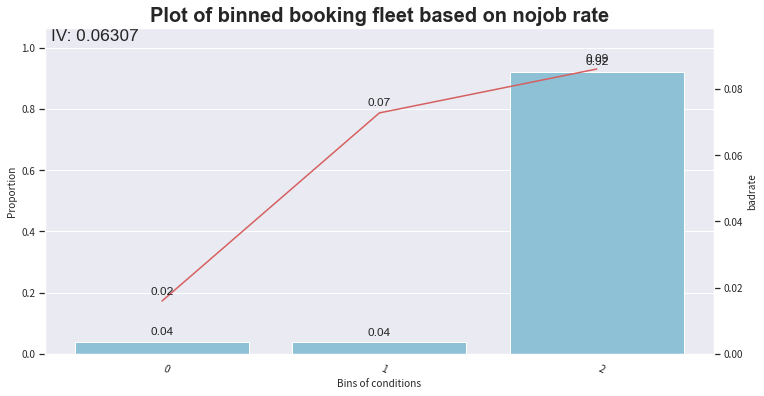

In [190]:
ax=bin_plot(c26.transform(data[['BookingFleet','target_2cls_NoJob']], labels=False), x='BookingFleet', target='target_2cls_NoJob')
ax.set_title("Plot of binned booking fleet based on nojob rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize the binning result and check for iv
#iv is quite high, binned booking fleet is a good feature for predicting NoJob

In [191]:
data['BookingFleetBins_NoJob'] = c26.transform(data[['BookingFleet']], labels=False) 
validation['BookingFleetBins_NoJob'] = c26.transform(validation[['BookingFleet']], labels=False) 
test['BookingFleetBins_NoJob'] = c26.transform(test[['BookingFleet']], labels=False)


In [192]:
data[['BookingID','BookingFleet','BookingFleetBins_Cancelled','BookingFleetBins_Completed','BookingFleetBins_ELSE','BookingFleetBins_NoJob']].head(10)

,BookingID,BookingFleet,BookingFleetBins_Cancelled,BookingFleetBins_Completed,BookingFleetBins_ELSE,BookingFleetBins_NoJob
0,171970588,13cabs Sydney,2,1,0,2
1,174526964,13cabs Sydney,2,1,0,2
2,180286324,13cabs Sydney,2,1,0,2
3,177228281,13cabs Sydney,2,1,0,2
4,170046024,13cabs Sydney,2,1,0,2
5,174863088,13cabs Sydney,2,1,0,2
6,169960932,13cabs Sydney,2,1,0,2
7,171324643,Silver Service Sydney,0,2,1,1
8,174080542,WATs Sydney,1,2,1,0
9,170182731,13cabs Sydney,2,1,0,2


## Booking Source

### Booking Source vs. Complete

In [193]:
c27 = toad.transform.Combiner()
c27.fit(data[['BookingSource','target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)
#use toad to bin booking source based on complete rate

In [194]:
c27.export()

{'BookingSource': [['Permanent', 'Internet'], ['TelOp'], ['StratumIVR']]}

Text(0, 0.5, 'Proportion')

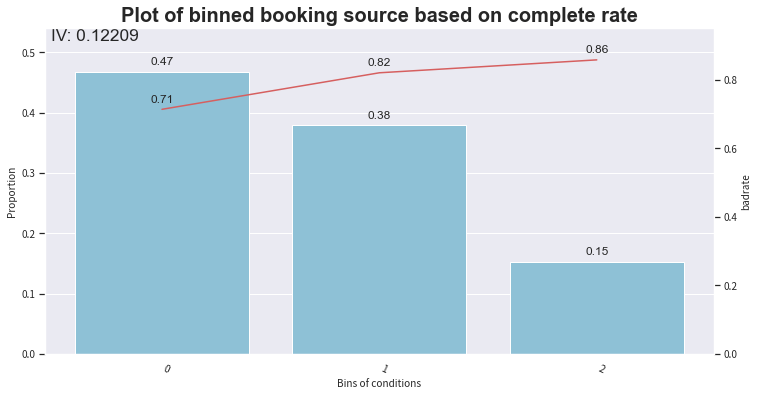

In [195]:
ax=bin_plot(c27.transform(data[['BookingSource','target_2cls_Completed']], labels=False), x='BookingSource', target='target_2cls_Completed')
ax.set_title("Plot of binned booking source based on complete rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize the binning result and check for iv
#iv is quite high, binned booking source is a good feature for predicting complete

Text(17.200000000000003, 0.5, 'Proportion')

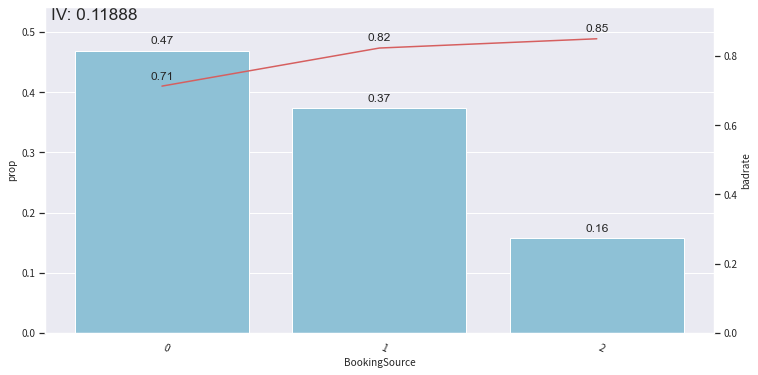

In [196]:
bin_plot(c27.transform(validation[['BookingSource','target_2cls_Completed']], labels=False), x='BookingSource', target='target_2cls_Completed') 
ax.set_title("Plot of binned booking source based on complete rate on validation set",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize the binning result on validation set and check for iv

In [197]:
data['BookingSourceBins_Completed'] = c27.transform(data[['BookingSource']], labels=False) 
validation['BookingSourceBins_Completed'] = c27.transform(validation[['BookingSource']], labels=False) 
test['BookingSourceBins_Completed'] = c27.transform(test[['BookingSource']], labels=False)


### Booking Source vs. Cancelled

In [198]:
c28 = toad.transform.Combiner()
c28.fit(data[['BookingSource','target_2cls_Cancelled']], y = 'target_2cls_Cancelled', method = 'chi',min_samples = 0.05)
#use toad to bin booking source based on Cancelled rate

In [199]:
c28.export()

{'BookingSource': [['StratumIVR'], ['TelOp'], ['Permanent', 'Internet']]}

Text(0, 0.5, 'Proportion')

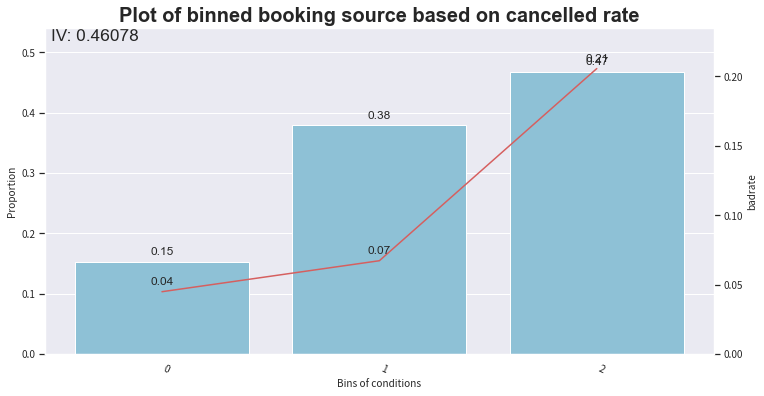

In [200]:
ax=bin_plot(c28.transform(data[['BookingSource','target_2cls_Cancelled']], labels=False), x='BookingSource', target='target_2cls_Cancelled')
ax.set_title("Plot of binned booking source based on cancelled rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize the binning result and check for iv
#iv is quite high, binned booking source is a good feature for predicting cancelled

In [201]:
data['BookingSourceBins_Cancelled'] = c28.transform(data[['BookingSource']], labels=False) 
validation['BookingSourceBins_Cancelled'] = c28.transform(validation[['BookingSource']], labels=False) 
test['BookingSourceBins_Cancelled'] = c28.transform(test[['BookingSource']], labels=False)


### Booking Source vs. ELSE

In [202]:
c29 = toad.transform.Combiner()
c29.fit(data[['BookingSource','target_2cls_ELSE']], y = 'target_2cls_ELSE', method = 'chi',min_samples = 0.05)
#use toad to bin booking source based on else rate

In [203]:
c29.export()

{'BookingSource': [['StratumIVR'], ['Internet'], ['TelOp', 'Permanent']]}

Text(0, 0.5, 'Proportion')

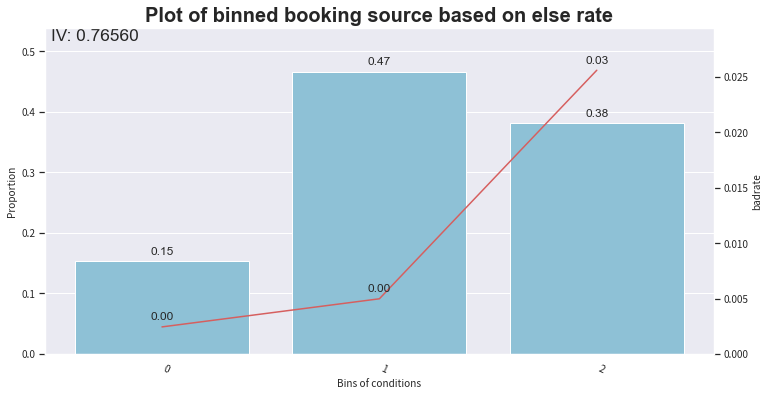

In [204]:
ax=bin_plot(c29.transform(data[['BookingSource','target_2cls_ELSE']], labels=False), x='BookingSource', target='target_2cls_ELSE')
ax.set_title("Plot of binned booking source based on else rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize the binning result and check for iv
#iv is quite high, binned booking source is a good feature for predicting else

In [205]:
data['BookingSourceBins_ELSE'] = c29.transform(data[['BookingSource']], labels=False) 
validation['BookingSourceBins_ELSE'] = c29.transform(validation[['BookingSource']], labels=False) 
test['BookingSourceBins_ELSE'] = c29.transform(test[['BookingSource']], labels=False)


### Booking Source vs. NoJob

In [206]:
c30 = toad.transform.Combiner()
c30.fit(data[['BookingSource','target_2cls_NoJob']], y = 'target_2cls_NoJob', method = 'chi',min_samples = 0.05)
#use toad to bin booking source based on NoJob rate

In [207]:
c30.export()

{'BookingSource': [['Internet', 'Permanent'], ['TelOp'], ['StratumIVR']]}

Text(0, 0.5, 'Proportion')

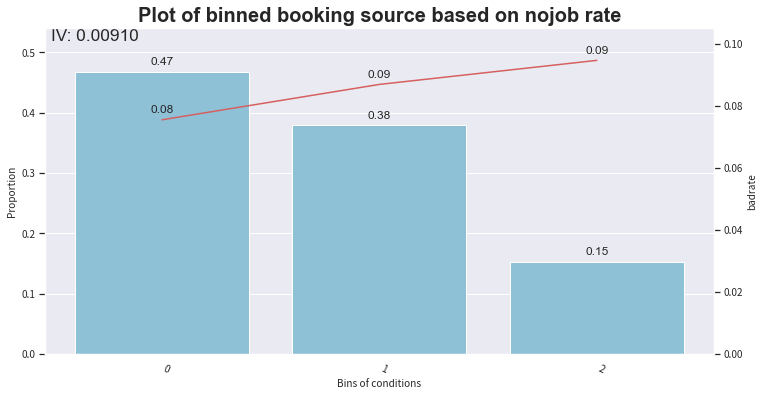

In [208]:
ax=bin_plot(c30.transform(data[['BookingSource','target_2cls_NoJob']], labels=False), x='BookingSource', target='target_2cls_NoJob')
ax.set_title("Plot of binned booking source based on nojob rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize the binning result and check for iv
#iv is quite low

In [209]:
data['BookingSourceBins_NoJob'] = c30.transform(data[['BookingSource']], labels=False) 
validation['BookingSourceBins_NoJob'] = c30.transform(validation[['BookingSource']], labels=False) 
test['BookingSourceBins_NoJob'] = c30.transform(test[['BookingSource']], labels=False)


In [210]:
data[['BookingID','BookingSource','BookingSourceBins_Cancelled','BookingSourceBins_Completed','BookingSourceBins_ELSE','BookingSourceBins_NoJob']].head()

,BookingID,BookingSource,BookingSourceBins_Cancelled,BookingSourceBins_Completed,BookingSourceBins_ELSE,BookingSourceBins_NoJob
0,171970588,TelOp,1,1,2,1
1,174526964,TelOp,1,1,2,1
2,180286324,Internet,2,0,1,0
3,177228281,StratumIVR,0,2,0,2
4,170046024,Internet,2,0,1,0


## Create dummy variables

In [211]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 53 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   BookingID                    int64         
 1   BookingSource                object        
 2   Conditions                   object        
 3   HasCondition                 object        
 4   IsAccountBooking             object        
 5   CreatedDate                  datetime64[ns]
 6   RequestedDate                datetime64[ns]
 7   BookingFleet                 object        
 8   DispatchFleet                object        
 9   AreaNumber                   int64         
 10  PuPlace                      object        
 11  PuAddress                    object        
 12  PuSuburb                     object        
 13  PuLat                        float64       
 14  PuLong                       float64       
 15  TargetVariable               object        
 16  

In [212]:
data['HasCondition']=np.where(data['HasCondition'] == 'Yes',1,0)
validation['HasCondition']=np.where(validation['HasCondition'] == 'Yes',1,0)
test['HasCondition']=np.where(test['HasCondition'] == 'Yes',1,0)

In [213]:
data['IsAccountBooking']=np.where(data['IsAccountBooking'] == 'Yes',1,0)
validation['IsAccountBooking']=np.where(validation['IsAccountBooking'] == 'Yes',1,0)
test['IsAccountBooking']=np.where(test['IsAccountBooking'] == 'Yes',1,0)

In [217]:
data['BookingisDispatch']=np.where(data['BookingisDispatch'] == True,1,0)
validation['BookingisDispatch']=np.where(validation['BookingisDispatch'] == True,1,0)
test['BookingisDispatch']=np.where(test['BookingisDispatch'] == True,1,0)

In [218]:
#create dummy variables for rest of the categorical variables

In [219]:
data.head()

,BookingID,BookingSource,Conditions,HasCondition,IsAccountBooking,CreatedDate,RequestedDate,BookingFleet,DispatchFleet,AreaNumber,...,DispatchFleetBins_ELSE,DispatchFleetBins_NoJob,BookingFleetBins_Completed,BookingFleetBins_Cancelled,BookingFleetBins_ELSE,BookingFleetBins_NoJob,BookingSourceBins_Completed,BookingSourceBins_Cancelled,BookingSourceBins_ELSE,BookingSourceBins_NoJob
0,171970588,TelOp,0,0,0,2019-04-11 10:36:55,2019-04-11 11:00:00,13cabs Sydney,13cabs Sydney,177,...,1,2,1,2,0,2,1,1,2,1
1,174526964,TelOp,0,0,0,2019-06-23 09:52:55,2019-06-23 09:52:55,13cabs Sydney,13cabs Sydney,111,...,1,2,1,2,0,2,1,1,2,1
2,180286324,Internet,0,0,0,2019-12-01 00:14:02,2019-12-01 00:14:02,13cabs Sydney,13cabs Sydney,92,...,1,2,1,2,0,2,0,2,1,0
3,177228281,StratumIVR,0,0,0,2019-09-12 09:07:03,2019-09-12 09:07:04,13cabs Sydney,13cabs Sydney,182,...,1,2,1,2,0,2,2,0,0,2
4,170046024,Internet,0,0,0,2019-02-21 21:37:04,2019-02-21 21:37:04,13cabs Sydney,13cabs Sydney,4,...,1,2,1,2,0,2,0,2,1,0


In [220]:
validation.head()

,BookingID,BookingSource,Conditions,HasCondition,IsAccountBooking,CreatedDate,RequestedDate,BookingFleet,DispatchFleet,AreaNumber,...,DispatchFleetBins_ELSE,DispatchFleetBins_NoJob,BookingFleetBins_Completed,BookingFleetBins_Cancelled,BookingFleetBins_ELSE,BookingFleetBins_NoJob,BookingSourceBins_Completed,BookingSourceBins_Cancelled,BookingSourceBins_ELSE,BookingSourceBins_NoJob
0,170605052,StratumIVR,0,0,0,2019-03-07 16:24:17,2019-03-07 16:24:18,13cabs Sydney,13cabs Sydney,181,...,1,2,1,2,0,2,2,0,0,2
1,175644382,Internet,0,0,0,2019-07-27 14:47:45,2019-07-27 14:47:45,13cabs Sydney,13cabs Sydney,95,...,1,2,1,2,0,2,0,2,1,0
2,168604643,TelOp,0,0,0,2019-01-15 11:36:47,2019-01-15 15:15:00,13cabs Sydney,Silver Service Sydney,221,...,0,0,1,2,0,2,1,1,2,1
3,169103600,TelOp,0,0,0,2019-01-29 18:00:00,2019-01-29 18:00:00,13cabs Sydney,13cabs Sydney,197,...,1,2,1,2,0,2,1,1,2,1
4,177600887,StratumIVR,0,0,0,2019-09-23 00:18:25,2019-09-23 00:18:25,13cabs Sydney,13cabs Sydney,179,...,1,2,1,2,0,2,2,0,0,2


In [221]:
test.head()

,BookingID,BookingSource,Conditions,HasCondition,IsAccountBooking,CreatedDate,RequestedDate,BookingFleet,DispatchFleet,AreaNumber,...,DispatchFleetBins_NoJob,BookingFleetBins_Completed,BookingFleetBins_Cancelled,BookingFleetBins_ELSE,BookingFleetBins_NoJob,BookingSourceBins_Completed,BookingSourceBins_Cancelled,BookingSourceBins_ELSE,BookingSourceBins_NoJob,BookingisDispatch
0,174627510,TelOp,0,0,0,2019-06-26 14:21:01,2019-06-26 14:21:01,13cabs Sydney,13cabs Sydney,275,...,2,1,2,0,2,1,1,2,1,0
1,176511990,Internet,0,0,0,2019-08-22 07:26:28,2019-08-22 07:26:28,13cabs Sydney,13cabs Sydney,89,...,2,1,2,0,2,0,2,1,0,0
2,170812542,TelOp,262144,1,0,2019-03-13 07:57:30,2019-03-13 15:30:00,WATs Sydney,WATs Sydney,52,...,1,2,1,1,0,1,1,2,1,0
3,171380931,Internet,274877906944,1,0,2019-03-27 09:20:50,2019-03-27 09:20:50,13cabs Sydney,13cabs Sydney,171,...,2,1,2,0,2,0,2,1,0,0
4,170281282,TelOp,4194304,1,0,2019-02-27 19:06:59,2019-02-28 05:15:00,13cabs Sydney,Silver Service Sydney,234,...,0,1,2,0,2,1,1,2,1,0


In [222]:
final=data.to_csv('final.csv')

In [223]:
final_val=validation.to_csv('final_val.csv')

In [224]:
final_test=test.to_csv('final_test.csv')

In [225]:
#save processed features

# Model

In [2]:
train = pd.read_csv('final.csv')

In [3]:
validation = pd.read_csv('final_val.csv')

In [5]:
test = pd.read_csv('final_test.csv')

In [4]:
train = train.iloc[:,1:]

In [5]:
validation = validation.iloc[:,1:]

In [8]:
test = test.iloc[:,1:]

In [13]:
test.head()

,BookingID,BookingSource,Conditions,HasCondition,IsAccountBooking,CreatedDate,RequestedDate,BookingFleet,DispatchFleet,AreaNumber,...,DispatchFleetBins_NoJob,BookingFleetBins_Completed,BookingFleetBins_Cancelled,BookingFleetBins_ELSE,BookingFleetBins_NoJob,BookingSourceBins_Completed,BookingSourceBins_Cancelled,BookingSourceBins_ELSE,BookingSourceBins_NoJob,BookingisDispatch
0,174627510,TelOp,0,0,0,2019-06-26 14:21:01,2019-06-26 14:21:01,13cabs Sydney,13cabs Sydney,275,...,2,1,2,0,2,1,1,2,1,0
1,176511990,Internet,0,0,0,2019-08-22 07:26:28,2019-08-22 07:26:28,13cabs Sydney,13cabs Sydney,89,...,2,1,2,0,2,0,2,1,0,0
2,170812542,TelOp,262144,1,0,2019-03-13 07:57:30,2019-03-13 15:30:00,WATs Sydney,WATs Sydney,52,...,1,2,1,1,0,1,1,2,1,0
3,171380931,Internet,274877906944,1,0,2019-03-27 09:20:50,2019-03-27 09:20:50,13cabs Sydney,13cabs Sydney,171,...,2,1,2,0,2,0,2,1,0,0
4,170281282,TelOp,4194304,1,0,2019-02-27 19:06:59,2019-02-28 05:15:00,13cabs Sydney,Silver Service Sydney,234,...,0,1,2,0,2,1,1,2,1,0


In [19]:
final_test = test[mdl_cols]

In [20]:
final_test['BookingID']=test['BookingID']

<ipython-input-20-90416141973d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_test['BookingID']=test['BookingID']


In [21]:
final_test.head()

,HasCondition,IsAccountBooking,PuSuburbBins_Cancelled,PuSuburbBins_Completed,PuSuburbBins_ELSE,PuSuburbBins_NoJob,PuLatLongKNN_Cancelled,PuLatLongKNN_Completed,PuLatLongKNN_ELSE,PuLatLongKNN_NoJob,...,DispatchFleetBins_NoJob,BookingFleetBins_Cancelled,BookingFleetBins_Completed,BookingFleetBins_ELSE,BookingFleetBins_NoJob,BookingSourceBins_Cancelled,BookingSourceBins_Completed,BookingSourceBins_ELSE,BookingSourceBins_NoJob,BookingID
0,0,0,5,1,1,6,0.079208,0.594059,0.118812,0.207921,...,2,2,1,0,2,1,1,2,1,174627510
1,0,0,1,6,0,3,0.059406,0.920792,0.000000,0.019802,...,2,2,1,0,2,2,0,1,0,176511990
2,1,0,6,0,1,4,0.356436,0.475248,0.099010,0.069307,...,1,1,2,1,0,1,1,2,1,170812542
3,1,0,4,2,1,5,0.188119,0.732673,0.009901,0.069307,...,2,2,1,0,2,2,0,1,0,171380931
4,1,0,1,6,0,2,0.099010,0.841584,0.029703,0.029703,...,0,2,1,0,2,1,1,2,1,170281282


In [22]:
final_test.columns

Index(['HasCondition', 'IsAccountBooking', 'PuSuburbBins_Cancelled',
       'PuSuburbBins_Completed', 'PuSuburbBins_ELSE', 'PuSuburbBins_NoJob',
       'PuLatLongKNN_Cancelled', 'PuLatLongKNN_Completed', 'PuLatLongKNN_ELSE',
       'PuLatLongKNN_NoJob', 'OrderHour', 'DayOfWeek', 'OrderTimeDT_Cancelled',
       'OrderTimeDT_Completed', 'OrderTimeDT_ELSE', 'OrderTimeDT_NoJob',
       'ConditionsBins_Cancelled', 'ConditionsBins_Completed',
       'ConditionsBins_ELSE', 'ConditionsBins_NoJob', 'BookingisDispatch',
       'DispatchFleetBins_Cancelled', 'DispatchFleetBins_Completed',
       'DispatchFleetBins_ELSE', 'DispatchFleetBins_NoJob',
       'BookingFleetBins_Cancelled', 'BookingFleetBins_Completed',
       'BookingFleetBins_ELSE', 'BookingFleetBins_NoJob',
       'BookingSourceBins_Cancelled', 'BookingSourceBins_Completed',
       'BookingSourceBins_ELSE', 'BookingSourceBins_NoJob', 'BookingID'],
      dtype='object')

In [23]:
final_test.to_pickle("./engineeredtest.pkl")
#use pickle to save engineered test data 

In [10]:
train.columns

Index(['BookingID', 'BookingSource', 'Conditions', 'HasCondition',
       'IsAccountBooking', 'CreatedDate', 'RequestedDate', 'BookingFleet',
       'DispatchFleet', 'AreaNumber', 'PuPlace', 'PuAddress', 'PuSuburb',
       'PuLat', 'PuLong', 'TargetVariable', 'target_2cls_Cancelled',
       'target_2cls_Completed', 'target_2cls_ELSE', 'target_2cls_NoJob',
       'target_4cls', 'PuSuburbBins_Completed', 'PuSuburbBins_Cancelled',
       'PuSuburbBins_ELSE', 'PuSuburbBins_NoJob', 'KNN_temp',
       'PuLatLongKNN_Completed', 'PuLatLongKNN_Cancelled', 'PuLatLongKNN_ELSE',
       'PuLatLongKNN_NoJob', 'OrderHour', 'DayOfWeek', 'OrderTimeDT_Completed',
       'OrderTimeDT_Cancelled', 'OrderTimeDT_ELSE', 'OrderTimeDT_NoJob',
       'ConditionsBins_Completed', 'ConditionsBins_Cancelled',
       'ConditionsBins_ELSE', 'ConditionsBins_NoJob', 'BookingisDispatch',
       'DispatchFleetBins_Completed', 'DispatchFleetBins_Cancelled',
       'DispatchFleetBins_ELSE', 'DispatchFleetBins_NoJob',
      

In [6]:
mdl_cols = ['HasCondition','IsAccountBooking',  'PuSuburbBins_Cancelled', 'PuSuburbBins_Completed',
       'PuSuburbBins_ELSE', 'PuSuburbBins_NoJob','PuLatLongKNN_Cancelled', 'PuLatLongKNN_Completed', 'PuLatLongKNN_ELSE',
       'PuLatLongKNN_NoJob', 'OrderHour', 'DayOfWeek', 
       'OrderTimeDT_Cancelled', 'OrderTimeDT_Completed', 'OrderTimeDT_ELSE',
       'OrderTimeDT_NoJob', 'ConditionsBins_Cancelled',
       'ConditionsBins_Completed', 'ConditionsBins_ELSE',
       'ConditionsBins_NoJob', 'BookingisDispatch',
       'DispatchFleetBins_Cancelled', 'DispatchFleetBins_Completed',
       'DispatchFleetBins_ELSE', 'DispatchFleetBins_NoJob',
       'BookingFleetBins_Cancelled', 'BookingFleetBins_Completed',
       'BookingFleetBins_ELSE', 'BookingFleetBins_NoJob',
       'BookingSourceBins_Cancelled', 'BookingSourceBins_Completed',
       'BookingSourceBins_ELSE', 'BookingSourceBins_NoJob']
#extract columns for modelling

## Logistic Regression-multinomial

In [71]:
#use multinomial to build the model
logit = LogisticRegression(multi_class = 'multinomial',solver = 'lbfgs',max_iter=10000)
logit.fit(train[mdl_cols],train['target_4cls'])

LogisticRegression(max_iter=10000, multi_class='multinomial')

In [72]:
logit.predict_proba(validation[mdl_cols])
#print out the probability for each class

array([[5.26419826e-02, 7.96104952e-01, 1.49298685e-01, 1.95438027e-03],
       [1.80206582e-01, 7.62148504e-01, 5.34226879e-02, 4.22222548e-03],
       [5.34208590e-04, 9.97066599e-01, 1.78749744e-03, 6.11694497e-04],
       ...,
       [6.55756316e-02, 8.64597826e-01, 6.61812600e-02, 3.64528284e-03],
       [3.45623606e-04, 9.97430195e-01, 1.67239887e-03, 5.51782427e-04],
       [4.23126421e-01, 4.07189703e-01, 8.81792959e-02, 8.15045801e-02]])

In [73]:
print('Training accuracy: ', accuracy_score(train['target_4cls'], logit.predict(train[mdl_cols])))
print('validation accuracy: ', accuracy_score(validation['target_4cls'], logit.predict(validation[mdl_cols])))
print('Training f1_score: ', f1_score(train['target_4cls'], logit.predict(train[mdl_cols]),average = 'weighted'))
print('validation f1_score: ', f1_score(validation['target_4cls'], logit.predict(validation[mdl_cols]), average = 'weighted'))
#training and validation accuracy and f1 score

Training accuracy:  0.7930166666666667
validation accuracy:  0.7924566666666667
Training f1_score:  0.8430707470652952
validation f1_score:  0.841923922609152


In [74]:
print('Validation accuracy of cancelled: ', accuracy_score(logit.predict(validation[mdl_cols]), validation['target_2cls_Cancelled']))
print('Validation accuracy of completed: ', accuracy_score(logit.predict(validation[mdl_cols]), validation['target_2cls_Completed']))
print('Validation accuracy of ELSE: ', accuracy_score(logit.predict(validation[mdl_cols]), validation['target_2cls_ELSE']))
print('Validation accuracy of No Job: ', accuracy_score(logit.predict(validation[mdl_cols]), validation['target_2cls_NoJob']))
#predicting accuracy for each class

Validation accuracy of cancelled:  0.12080666666666667
Validation accuracy of completed:  0.7958333333333333
Validation accuracy of ELSE:  0.06942
Validation accuracy of No Job:  0.12022666666666666


In [75]:
logit_proba = pd.DataFrame(data = logit.predict_proba(validation[mdl_cols]), columns = ['Cancelled','Completed','ELSE','NoJob'])
logit_proba.corr()
#use pearson correlation to check the correlation between each classess.

,Cancelled,Completed,ELSE,NoJob
Cancelled,1.000000,-0.890068,0.272940,0.137722
Completed,-0.890068,1.000000,-0.656196,-0.285433
ELSE,0.272940,-0.656196,1.000000,0.064220
NoJob,0.137722,-0.285433,0.064220,1.000000


In [76]:
logit.coef_
#coefficients of regression

array([[ 5.12209076e-01,  5.74707148e-01,  1.78799742e-02,
        -2.54248562e-03,  2.85767889e-02, -3.41532635e-02,
         2.60291768e+00, -1.70696753e-01, -4.99207806e-01,
        -1.14345987e+00,  6.80402529e-03, -1.58645500e-03,
         1.83511909e+00,  8.20424668e-01,  5.78393388e-01,
         1.66290945e+00,  4.19742782e-02, -1.17429338e-01,
        -6.90934481e-01, -1.76917370e-01,  0.00000000e+00,
         1.74505668e+00,  5.07644639e-01,  9.36554602e-02,
         2.85759022e-01, -1.16339172e+00, -1.32026743e+00,
        -2.11495381e+00, -8.39427171e-01,  1.28373940e+00,
         2.95367115e-01, -5.81292346e-01,  2.95367115e-01],
       [-1.94570967e+00,  5.45159098e-01, -7.04154125e-02,
        -6.09808182e-02, -4.17957455e-02,  1.73854951e-03,
         5.84647651e-01,  3.01392686e+00, -4.49442353e+00,
         3.55335758e-01,  7.08572958e-03, -2.44256352e-03,
        -2.94305668e+00, -1.35633167e+00, -2.01845311e+00,
        -4.29169900e+00,  7.29589868e-02,  1.03468850e-

In [77]:
logit.intercept_
#intercept of regression

array([ 0.88870652, -0.63227906, -2.09158199,  1.83515453])

In [78]:
val_pred_logit = logit.predict(validation[mdl_cols])

In [79]:
print(classification_report(validation['target_4cls'], val_pred_logit))
print(confusion_matrix(validation['target_4cls'], val_pred_logit))
#classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.59      0.27      0.37     40250
           1       0.81      0.97      0.88    232675
           2       0.33      0.05      0.09     23166
           3       0.34      0.04      0.07      3909

    accuracy                           0.79    300000
   macro avg       0.52      0.33      0.35    300000
weighted avg       0.74      0.79      0.74    300000

[[ 10717  28914    509    110]
 [  4938 225643   1927    167]
 [  1951  19974   1221     20]
 [   439   3220     94    156]]


## Logistic regression-ovr

In [80]:
#use ovr extention to build the model
logit_ovr = LogisticRegression(multi_class = 'ovr',max_iter=10000) # 'one_vs_rest'
logit_ovr.fit(train[mdl_cols],train['target_4cls'])

LogisticRegression(max_iter=10000, multi_class='ovr')

In [81]:
print('Training accuracy: ', accuracy_score(train['target_4cls'], logit_ovr.predict(train[mdl_cols])))
print('validation accuracy: ', accuracy_score(validation['target_4cls'], logit_ovr.predict(validation[mdl_cols])))
print('Training f1_score: ', f1_score(train['target_4cls'], logit_ovr.predict(train[mdl_cols]),average = 'weighted'))
print('validation f1_score: ', f1_score(validation['target_4cls'], logit_ovr.predict(validation[mdl_cols]), average = 'weighted'))
#training and validation accuracy and f1 score

Training accuracy:  0.792928
validation accuracy:  0.79231
Training f1_score:  0.844988633034274
validation f1_score:  0.8437169803284459


In [82]:
print('Training accuracy of cancelled: ', accuracy_score(logit_ovr.predict(train[mdl_cols]), train['target_2cls_Cancelled']))
print('Training accuracy of completed: ', accuracy_score(logit_ovr.predict(train[mdl_cols]), train['target_2cls_Completed']))
print('Training accuracy of ELSE: ', accuracy_score(logit_ovr.predict(train[mdl_cols]), train['target_2cls_ELSE']))
print('Training accuracy of No Job: ', accuracy_score(logit_ovr.predict(train[mdl_cols]), train['target_2cls_NoJob']))
#accuracy for each class

Training accuracy of cancelled:  0.11806166666666666
Training accuracy of completed:  0.7979533333333333
Training accuracy of ELSE:  0.06774466666666666
Training accuracy of No Job:  0.122394


In [83]:
logit_ovr.coef_
#coefficients

array([[ 1.92448445e+00,  1.31747952e-01,  6.59551394e-02,
         3.42341169e-02,  8.94723612e-02, -3.97174128e-02,
         2.29340470e+00, -2.43019403e+00,  1.81347851e+00,
        -2.61708360e+00,  3.75838292e-04, -3.60547273e-03,
         3.96324899e+00,  7.33235658e-01,  8.17889453e-01,
         2.66943766e+00,  2.48004869e-02, -2.33624281e-01,
        -1.77139691e+00, -6.93159315e-02,  0.00000000e+00,
         3.87207761e+00, -1.12152120e+00, -1.18442489e+00,
         2.99778013e-01, -1.13671989e+00,  8.88683270e-02,
        -6.85570163e-01,  1.51752490e+00, -9.62862951e-01,
        -9.17925875e-01, -4.73001473e-01, -9.17925875e-01],
       [-2.50507935e+00,  2.25628554e-01, -8.09330119e-02,
        -5.89186675e-02, -2.09986366e-02,  1.60774992e-02,
        -5.41203779e-01,  3.43609179e+00, -4.01643202e+00,
        -1.51009001e+00,  8.24377966e-04, -4.55832974e-03,
        -2.77791654e+00, -1.61371756e+00, -1.92350327e+00,
        -6.68494915e+00,  5.14459815e-02,  1.17353553e-

In [84]:
logit_ovr.intercept_
#intercept

array([-1.04369912, -2.86161571, -4.50405727,  1.3538973 ])

In [85]:
val_pred_ovr = logit_ovr.predict(validation[mdl_cols])

In [86]:
print(classification_report(validation['target_4cls'], val_pred_ovr))
print(confusion_matrix(validation['target_4cls'], val_pred_ovr))
#classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.59      0.26      0.36     40250
           1       0.81      0.97      0.88    232675
           2       0.30      0.04      0.07     23166
           3       0.34      0.03      0.05      3909

    accuracy                           0.79    300000
   macro avg       0.51      0.33      0.34    300000
weighted avg       0.74      0.79      0.74    300000

[[ 10607  29161    418     64]
 [  4820 226035   1683    137]
 [  2103  20108    943     12]
 [   480   3242     79    108]]


## Random Forest

### Without hyperparameter tuning

In [12]:
rf = RandomForestClassifier()

rf.fit(train[mdl_cols],train['target_4cls'])
#use random forest classifier to build the model

RandomForestClassifier()

In [13]:
print('Training accuracy: ', accuracy_score(train['target_4cls'], rf.predict(train[mdl_cols])))
print('validation accuracy: ', accuracy_score(validation['target_4cls'], rf.predict(validation[mdl_cols])))
print('Training f1_score: ', f1_score(train['target_4cls'], rf.predict(train[mdl_cols]),average = 'weighted'))
print('validation f1_score: ', f1_score(validation['target_4cls'], rf.predict(validation[mdl_cols]), average = 'weighted'))
#training and validation accuracy and f1 score

Training accuracy:  0.9366373333333333
validation accuracy:  0.7820633333333333
Training f1_score:  0.9344169787775648
validation f1_score:  0.7599601534827505


In [14]:
print('Validation accuracy of cancelled: ', accuracy_score(rf.predict(validation[mdl_cols]), validation['target_2cls_Cancelled']))
print('Validation accuracy of completed: ', accuracy_score(rf.predict(validation[mdl_cols]), validation['target_2cls_Completed']))
print('Validation accuracy of ELSE: ', accuracy_score(rf.predict(validation[mdl_cols]), validation['target_2cls_ELSE']))
print('Validation accuracy of No Job: ', accuracy_score(rf.predict(validation[mdl_cols]), validation['target_2cls_NoJob']))
#accuracy for each class, complete has the highest accuracy

Validation accuracy of cancelled:  0.12309
Validation accuracy of completed:  0.7809066666666666
Validation accuracy of ELSE:  0.10385333333333334
Validation accuracy of No Job:  0.14220333333333332


In [15]:
val_pred_rf = rf.predict(validation[mdl_cols])

In [16]:
print(classification_report(validation['target_4cls'], val_pred_rf))
print(confusion_matrix(validation['target_4cls'], val_pred_rf))
#classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.51      0.37      0.43     40250
           1       0.84      0.93      0.88    232675
           2       0.30      0.16      0.21     23166
           3       0.32      0.15      0.20      3909

    accuracy                           0.78    300000
   macro avg       0.49      0.40      0.43    300000
weighted avg       0.75      0.78      0.76    300000

[[ 15069  22274   2472    435]
 [ 10689 215239   6107    640]
 [  3176  16115   3735    140]
 [   788   2222    323    576]]


array([0.006, 0.004, 0.042, 0.039, 0.011, 0.058, 0.107, 0.118, 0.052,
       0.093, 0.084, 0.112, 0.016, 0.017, 0.028, 0.015, 0.003, 0.011,
       0.008, 0.017, 0.   , 0.036, 0.027, 0.027, 0.021, 0.004, 0.003,
       0.003, 0.003, 0.012, 0.01 , 0.004, 0.01 ])

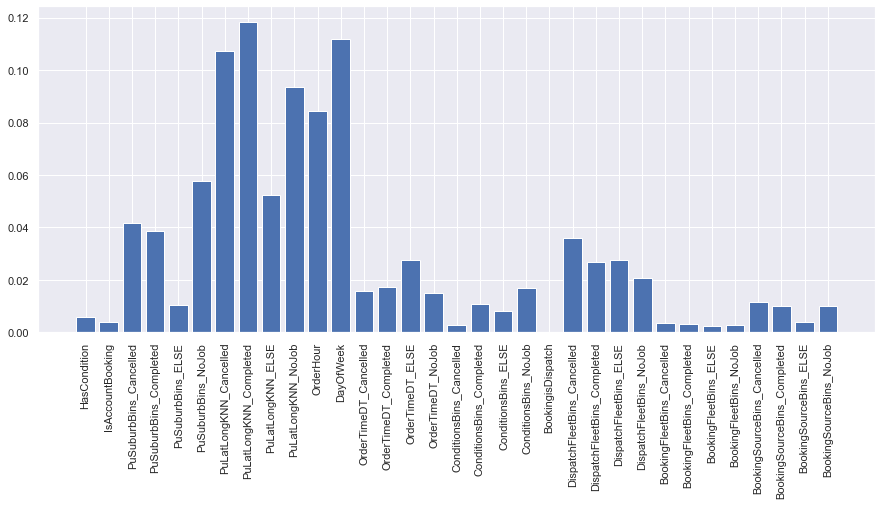

In [17]:
#extract feature importance
plt.figure(figsize=(15,6))
plt.bar(train[mdl_cols].columns.tolist(),rf.feature_importances_)
plt.xticks(rotation=90)
rf.feature_importances_.round(3)

In [18]:
pd.DataFrame(rf.feature_importances_.round(3).T,train[mdl_cols].columns).sort_values(0, ascending = False)
#print out feature importance

,0
PuLatLongKNN_Completed,0.118
DayOfWeek,0.112
PuLatLongKNN_Cancelled,0.107
PuLatLongKNN_NoJob,0.093
OrderHour,0.084
PuSuburbBins_NoJob,0.058
PuLatLongKNN_ELSE,0.052
PuSuburbBins_Cancelled,0.042
PuSuburbBins_Completed,0.039
DispatchFleetBins_Cancelled,0.036


### With hyperparameter tuning

In [8]:
%%time

model = RandomForestClassifier()

tuning_parameters = {
    'n_estimators':[200,400,600,800],
    'max_depth':[10,20,40],
    'min_samples_leaf': [2,4],
    'min_samples_split': [2,5],
}

rf_search = RandomizedSearchCV(model, tuning_parameters, cv = 3, n_iter= 4, n_jobs=4)
rf_search.fit(train[mdl_cols],train['target_4cls'])

rft = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

Best parameters found by randomised search: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 40} 

CPU times: user 1h 39min 37s, sys: 1min, total: 1h 40min 37s
Wall time: 6h 52min 5s


In [9]:
print('Training accuracy: ', accuracy_score(train['target_4cls'], rft.predict(train[mdl_cols])))
print('validation accuracy: ', accuracy_score(validation['target_4cls'], rft.predict(validation[mdl_cols])))
print('Training f1_score: ', f1_score(train['target_4cls'], rft.predict(train[mdl_cols]),average = 'weighted'))
print('validation f1_score: ', f1_score(validation['target_4cls'], rft.predict(validation[mdl_cols]), average = 'weighted'))
#training and validation accuracy and f1 score

Training accuracy:  0.8352793333333334
validation accuracy:  0.80386
Training f1_score:  0.8000503596968799
validation f1_score:  0.7604658639423767


In [10]:
print('Validation accuracy of cancelled: ', accuracy_score(rft.predict(validation[mdl_cols]), validation['target_2cls_Cancelled']))
print('Validation accuracy of completed: ', accuracy_score(rft.predict(validation[mdl_cols]), validation['target_2cls_Completed']))
print('Validation accuracy of ELSE: ', accuracy_score(rft.predict(validation[mdl_cols]), validation['target_2cls_ELSE']))
print('Validation accuracy of No Job: ', accuracy_score(rft.predict(validation[mdl_cols]), validation['target_2cls_NoJob']))
#accuracy for each class, complete has the highest accuracy

Validation accuracy of cancelled:  0.1157
Validation accuracy of completed:  0.8065633333333333
Validation accuracy of ELSE:  0.07786
Validation accuracy of No Job:  0.12717666666666666


In [11]:
val_pred_rft = rft.predict(validation[mdl_cols])

In [12]:
print(classification_report(validation['target_4cls'], val_pred_rft))
print(confusion_matrix(validation['target_4cls'], val_pred_rft))
#classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.61      0.32      0.42     40250
           1       0.82      0.97      0.89    232675
           2       0.45      0.07      0.13     23166
           3       0.64      0.11      0.18      3909

    accuracy                           0.80    300000
   macro avg       0.63      0.37      0.41    300000
weighted avg       0.76      0.80      0.76    300000

[[ 12989  26373    737    151]
 [  5414 226057   1174     30]
 [  2294  19121   1698     53]
 [   629   2661    205    414]]


array([0.011, 0.007, 0.032, 0.03 , 0.01 , 0.037, 0.098, 0.11 , 0.035,
       0.079, 0.044, 0.049, 0.014, 0.015, 0.019, 0.013, 0.004, 0.02 ,
       0.015, 0.032, 0.   , 0.058, 0.059, 0.062, 0.049, 0.008, 0.007,
       0.005, 0.006, 0.023, 0.019, 0.007, 0.025])

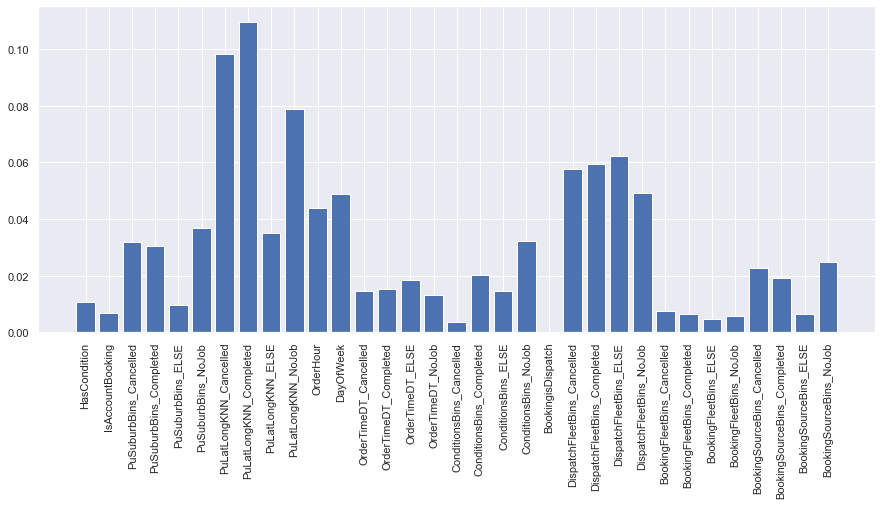

In [13]:
#extract feature importance
plt.figure(figsize=(15,6))
plt.bar(train[mdl_cols].columns.tolist(),rft.feature_importances_)
plt.xticks(rotation=90)
rft.feature_importances_.round(3)

In [15]:
pd.DataFrame(rft.feature_importances_.round(3).T,train[mdl_cols].columns).sort_values(0, ascending = False)
#print out feature importance

,0
PuLatLongKNN_Completed,0.110
PuLatLongKNN_Cancelled,0.098
PuLatLongKNN_NoJob,0.079
DispatchFleetBins_ELSE,0.062
DispatchFleetBins_Completed,0.059
DispatchFleetBins_Cancelled,0.058
DispatchFleetBins_NoJob,0.049
DayOfWeek,0.049
OrderHour,0.044
PuSuburbBins_NoJob,0.037


## XGBoost

### With hyperparameter tuning

In [23]:
%%time

model = xgboost.XGBClassifier()

search_space = {
    #'learning_rate': [0.005,0.1], 
    'n_estimators' : [50,200,500], 
    'max_depth' : [2, 3, 4], 
    'subsample' : [0.5, 1], 
}

xbst = RandomizedSearchCV(model, search_space, n_iter = 4, cv = 3, random_state=87)
xbst.fit(train[mdl_cols], train['target_4cls'])

print('Best parameters found by randomised search:', xbst.best_params_, '\n')


xbst = xbst.best_estimator_
#hyperparameter tuning for xgboost and save the best model

/Users/Crystal/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:46:03] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/Crystal/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:51:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/Crystal/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/Crystal/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:01:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/Crystal/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/Crystal/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:08:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/Crystal/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:12:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/Crystal/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:43:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/Crystal/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:13:52] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/Crystal/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:46:51] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/Crystal/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:10:49] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/Crystal/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:34:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/Crystal/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters found by randomised search: {'subsample': 0.5, 'n_estimators': 200, 'max_depth': 4} 

CPU times: user 13h 32min 25s, sys: 7min 15s, total: 13h 39min 40s
Wall time: 4h 5min 6s


In [40]:
print('Training accuracy: ', accuracy_score(train['target_4cls'], xbst.predict(train[mdl_cols])))
print('validation accuracy: ', accuracy_score(validation['target_4cls'], xbst.predict(validation[mdl_cols])))
print('Training f1_score: ', f1_score(train['target_4cls'], xbst.predict(train[mdl_cols]),average = 'weighted'))
print('validation f1_score: ', f1_score(validation['target_4cls'], xbst.predict(validation[mdl_cols]), average = 'weighted'))
#training and validation accuracy and f1 score

Training accuracy:  0.8024586666666667
validation accuracy:  0.8011166666666667
Training f1_score:  0.7520377778221701
validation f1_score:  0.7510842732377594


In [42]:
print('Validation accuracy of cancelled: ', accuracy_score(validation['target_2cls_Cancelled'],xbst.predict(validation[mdl_cols])))
print('Validation accuracy of completed: ', accuracy_score(validation['target_2cls_Completed'],xbst.predict(validation[mdl_cols])))
print('Validation accuracy of ELSE: ', accuracy_score(validation['target_2cls_ELSE'],xbst.predict(validation[mdl_cols])))
print('Validation accuracy of No Job: ', accuracy_score(validation['target_2cls_NoJob'], xbst.predict(validation[mdl_cols])))
#accuracy for each class, complete has the highest accuracy

Validation accuracy of cancelled:  0.11809
Validation accuracy of completed:  0.80497
Validation accuracy of ELSE:  0.07012
Validation accuracy of No Job:  0.12256666666666667


In [26]:
val_pred_xbst = xbst.predict(validation[mdl_cols])

In [28]:
print(classification_report(validation['target_4cls'], val_pred_xbst))
print(confusion_matrix(validation['target_4cls'], val_pred_xbst))
#classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.61      0.28      0.39     40250
           1       0.82      0.98      0.89    232675
           2       0.47      0.05      0.08     23166
           3       0.61      0.10      0.17      3909

    accuracy                           0.80    300000
   macro avg       0.63      0.35      0.38    300000
weighted avg       0.76      0.80      0.75    300000

[[ 11470  28099    509    172]
 [  4735 227428    485     27]
 [  2048  20020   1044     54]
 [   545   2783    188    393]]


array([0.035, 0.016, 0.004, 0.003, 0.004, 0.003, 0.015, 0.024, 0.013,
       0.019, 0.002, 0.001, 0.005, 0.008, 0.001, 0.007, 0.007, 0.007,
       0.026, 0.054, 0.   , 0.414, 0.022, 0.025, 0.108, 0.033, 0.026,
       0.005, 0.021, 0.08 , 0.   , 0.011, 0.   ], dtype=float32)

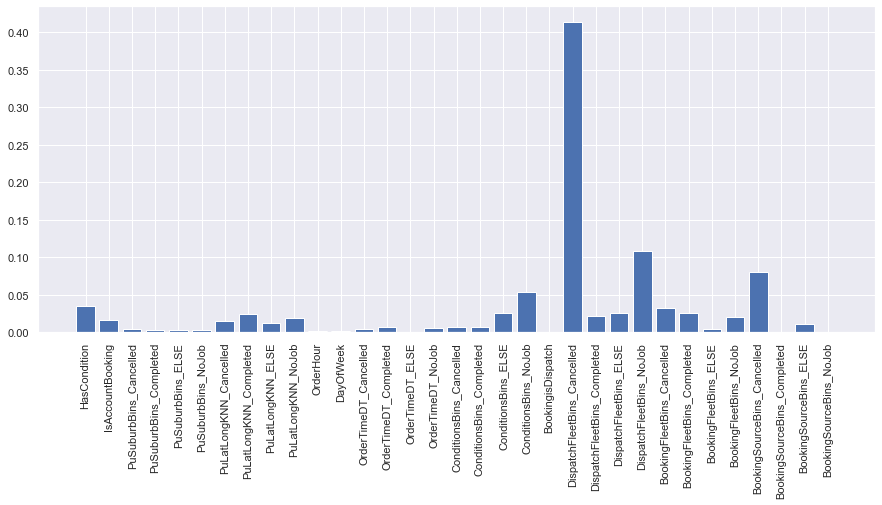

In [29]:
#extract feature importance
plt.figure(figsize=(15,6))
plt.bar(train[mdl_cols].columns.tolist(),xbst.feature_importances_)
plt.xticks(rotation=90)
xbst.feature_importances_.round(3)

In [31]:
pd.DataFrame(xbst.feature_importances_.round(3).T,train[mdl_cols].columns).sort_values(0, ascending = False)
#print out feature importance

,0
DispatchFleetBins_Cancelled,0.414
DispatchFleetBins_NoJob,0.108
BookingSourceBins_Cancelled,0.080
ConditionsBins_NoJob,0.054
HasCondition,0.035
BookingFleetBins_Cancelled,0.033
BookingFleetBins_Completed,0.026
ConditionsBins_ELSE,0.026
DispatchFleetBins_ELSE,0.025
PuLatLongKNN_Completed,0.024


In [32]:
xbst_pred=xbst.predict(test[mdl_cols])
#make predictions

In [34]:
replacements = {
    0:'Cancelled',
    1:'Completed',
    2:'No Job',
    3:'ELSE',
}

xbst_pred= [replacements.get(x, x) for x in xbst_pred]
#replace encoded target with original target variables

In [35]:
xbst_csv=pd.DataFrame(columns=['BookingID','PredictedTarget'])
xbst_csv['BookingID'] = test['BookingID']
xbst_csv['PredictedTarget']=xbst_pred
xbst_csv.head()
#save predictions to csv

,BookingID,PredictedTarget
0,174627510,Completed
1,176511990,Completed
2,170812542,Completed
3,171380931,Completed
4,170281282,Completed


In [36]:
filename = 'xbst_model.sav'
pickle.dump(xbst, open(filename, 'wb'))
#use pickle to save our best model

### without hyperparameter tuning

In [14]:
xgb = xgboost.XGBClassifier(n_estimators = 500, max_depth = 3)
xgb.fit(train[mdl_cols],train['target_4cls'])
#use xgboost to build the model without hyperparameter tuning

/Users/Crystal/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:57:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [41]:
print('Training accuracy: ', accuracy_score(train['target_4cls'], xgb.predict(train[mdl_cols])))
print('validation accuracy: ', accuracy_score(validation['target_4cls'], xgb.predict(validation[mdl_cols])))
print('Training f1_score: ', f1_score(train['target_4cls'], xgb.predict(train[mdl_cols]),average = 'weighted'))
print('validation f1_score: ', f1_score(validation['target_4cls'], xgb.predict(validation[mdl_cols]), average = 'weighted'))
#training and validation accuracy and f1 score

Training accuracy:  0.8022496666666666
validation accuracy:  0.8010533333333333
Training f1_score:  0.7518948149814787
validation f1_score:  0.7511091232179906


In [16]:
print('Validation accuracy of cancelled: ', accuracy_score(xgb.predict(validation[mdl_cols]), validation['target_2cls_Cancelled']))
print('Validation accuracy of completed: ', accuracy_score(xgb.predict(validation[mdl_cols]), validation['target_2cls_Completed']))
print('Validation accuracy of ELSE: ', accuracy_score(xgb.predict(validation[mdl_cols]), validation['target_2cls_ELSE']))
print('Validation accuracy of No Job: ', accuracy_score(xgb.predict(validation[mdl_cols]), validation['target_2cls_NoJob']))
#accuracy for each class, complete has the highest accuracy

Validation accuracy of cancelled:  0.11819
Validation accuracy of completed:  0.80499
Validation accuracy of ELSE:  0.07058333333333333
Validation accuracy of No Job:  0.12317


In [17]:
val_pred_xgb = xgb.predict(validation[mdl_cols])

In [18]:
print(classification_report(validation['target_4cls'], val_pred_xgb))
print(confusion_matrix(validation['target_4cls'], val_pred_xgb))
#classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.61      0.29      0.39     40250
           1       0.82      0.98      0.89    232675
           2       0.47      0.04      0.08     23166
           3       0.58      0.10      0.17      3909

    accuracy                           0.80    300000
   macro avg       0.62      0.35      0.38    300000
weighted avg       0.76      0.80      0.75    300000

[[ 11529  28024    515    182]
 [  4834 227369    445     27]
 [  2038  20027   1041     60]
 [   561   2774    197    377]]


array([0.053, 0.006, 0.002, 0.001, 0.003, 0.002, 0.013, 0.02 , 0.011,
       0.019, 0.001, 0.001, 0.004, 0.007, 0.001, 0.005, 0.006, 0.008,
       0.015, 0.043, 0.   , 0.484, 0.021, 0.012, 0.1  , 0.025, 0.032,
       0.007, 0.012, 0.075, 0.   , 0.01 , 0.   ], dtype=float32)

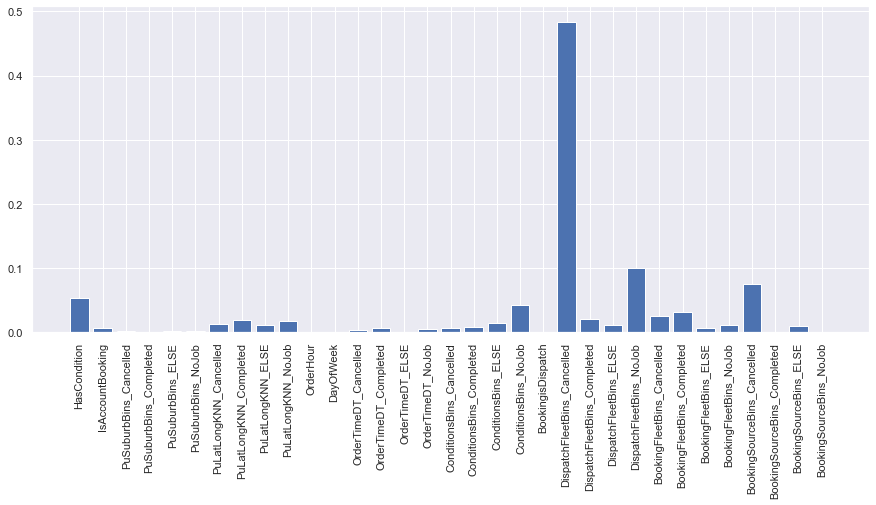

In [19]:
#extract feature importance
plt.figure(figsize=(15,6))
plt.bar(train[mdl_cols].columns.tolist(),xgb.feature_importances_)
plt.xticks(rotation=90)
xgb.feature_importances_.round(3)

In [20]:
pd.DataFrame(xgb.feature_importances_.round(3).T,train[mdl_cols].columns).sort_values(0, ascending = False)
#print out feature importance

,0
DispatchFleetBins_Cancelled,0.484
DispatchFleetBins_NoJob,0.100
BookingSourceBins_Cancelled,0.075
HasCondition,0.053
ConditionsBins_NoJob,0.043
BookingFleetBins_Completed,0.032
BookingFleetBins_Cancelled,0.025
DispatchFleetBins_Completed,0.021
PuLatLongKNN_Completed,0.020
PuLatLongKNN_NoJob,0.019


## Light GBM

### Without hyperparameter tuning

In [9]:
import lightgbm

In [12]:
lgb = lightgbm.LGBMClassifier(n_estimators = 200, max_depth = 4, objective= 'multiclass')
lgb.fit(train[mdl_cols],train['target_4cls']) 
#use lightgbm to build the model

LGBMClassifier(max_depth=4, n_estimators=200, objective='multiclass')

In [13]:
print('Training accuracy: ', accuracy_score(train['target_4cls'], lgb.predict(train[mdl_cols])))
print('validation accuracy: ', accuracy_score(validation['target_4cls'], lgb.predict(validation[mdl_cols])))
print('Training f1_score: ', f1_score(train['target_4cls'], lgb.predict(train[mdl_cols]),average = 'weighted'))
print('validation f1_score: ', f1_score(validation['target_4cls'], lgb.predict(validation[mdl_cols]), average = 'weighted'))
#training and validation accuracy and f1 score

Training accuracy:  0.8016773333333334
validation accuracy:  0.80068
Training f1_score:  0.7504767693619357
validation f1_score:  0.7499865411881036


In [14]:
print('Validation accuracy of cancelled: ', accuracy_score(lgb.predict(validation[mdl_cols]), validation['target_2cls_Cancelled']))
print('Validation accuracy of completed: ', accuracy_score(lgb.predict(validation[mdl_cols]), validation['target_2cls_Completed']))
print('Validation accuracy of ELSE: ', accuracy_score(lgb.predict(validation[mdl_cols]), validation['target_2cls_ELSE']))
print('Validation accuracy of No Job: ', accuracy_score(lgb.predict(validation[mdl_cols]), validation['target_2cls_NoJob']))
#accuracy for each class, complete has the highest accuracy

Validation accuracy of cancelled:  0.11832666666666666
Validation accuracy of completed:  0.8046566666666667
Validation accuracy of ELSE:  0.06930666666666667
Validation accuracy of No Job:  0.12202666666666667


In [15]:
val_pred_lgb = lgb.predict(validation[mdl_cols])

In [16]:
print(classification_report(validation['target_4cls'], val_pred_lgb))
print(confusion_matrix(validation['target_4cls'], val_pred_lgb))
#classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.61      0.28      0.38     40250
           1       0.82      0.98      0.89    232675
           2       0.47      0.04      0.08     23166
           3       0.60      0.09      0.16      3909

    accuracy                           0.80    300000
   macro avg       0.62      0.35      0.38    300000
weighted avg       0.76      0.80      0.75    300000

[[ 11303  28277    513    157]
 [  4661 227534    450     30]
 [  2011  20095   1015     45]
 [   549   2817    191    352]]


array([ 171,  370,  503,  536,  189,  682, 1049, 1004,  586, 1037,  921,
        449,  267,  159,  122,  165,  205,  375,  222,  479,    0,  306,
        199,   26,  221,  356,  123,   89,  229,  385,   82,  325,    0],
      dtype=int32)

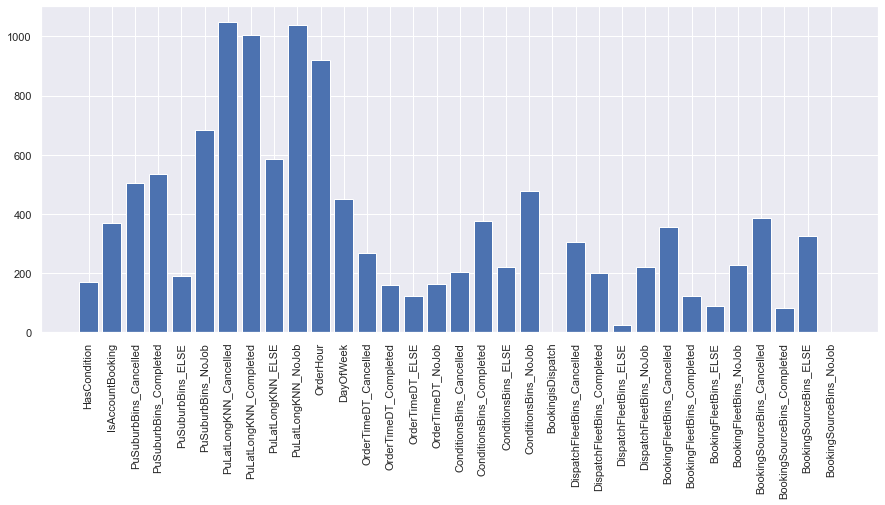

In [19]:
#extract feature importance
plt.figure(figsize=(15,6))
plt.bar(train[mdl_cols].columns.tolist(),lgb.feature_importances_)
plt.xticks(rotation=90)
lgb.feature_importances_.round(3)

In [18]:
pd.DataFrame(lgb.feature_importances_.T,train[mdl_cols].columns).sort_values(0, ascending = False)
#print out feature importance

,0
PuLatLongKNN_Cancelled,1049
PuLatLongKNN_NoJob,1037
PuLatLongKNN_Completed,1004
OrderHour,921
PuSuburbBins_NoJob,682
PuLatLongKNN_ELSE,586
PuSuburbBins_Completed,536
PuSuburbBins_Cancelled,503
ConditionsBins_NoJob,479
DayOfWeek,449


### With hyperparameter tuning

In [22]:
from scipy.stats import uniform as unif
from scipy.stats import randint

In [23]:
%%time

model = lightgbm.LGBMClassifier()

search_space = {
    'learning_rate': unif(0.005,0.1), # uniform distribution between 0.005 and 0.1
    'n_estimators' : randint(100, 2501), # discrete uniform distribution between 100 and 2500
    'num_leaves' : randint(2, 65), # discrete uniform distribution between 2 and 4
    'subsample' : unif(0.5, 1), # uniform distribution between 0.5 and 1
}

lbst = RandomizedSearchCV(model, search_space, n_iter = 4, cv = 3, random_state=1,n_jobs=4)
lbst.fit(train[mdl_cols], train['target_4cls'])

print('Best parameters found by randomised search:', lbst.best_params_, '\n')


lbst = lbst.best_estimator_
#hyperparameter tuning for lightgbm and save the best model

Best parameters found by randomised search: {'learning_rate': 0.03955607270430477, 'n_estimators': 1302, 'num_leaves': 22, 'subsample': 0.9191945144032948} 

CPU times: user 32min 1s, sys: 41.7 s, total: 32min 42s
Wall time: 1h 44min 40s


In [10]:
lbst = lightgbm.LGBMClassifier(learning_rate = 0.03955607270430477,
                               n_estimators = 1302, num_leaves = 22,
                               subsample = 0.9191945144032948, objective= 'multiclass')
lbst.fit(train[mdl_cols],train['target_4cls']) 
#use lightgbm with tuned parameters to build the model

LGBMClassifier(learning_rate=0.03955607270430477, n_estimators=1302,
               num_leaves=22, objective='multiclass',
               subsample=0.9191945144032948)

In [ ]:
#print('Training accuracy: ', accuracy_score(train['target_4cls'], lbst.predict(train[mdl_cols])))
#print('validation accuracy: ', accuracy_score(validation['target_4cls'], lbst.predict(validation[mdl_cols])))
#print('Training f1_score: ', f1_score(train['target_4cls'], lbst.predict(train[mdl_cols]),average = 'weighted'))
#print('validation f1_score: ', f1_score(validation['target_4cls'], lbst.predict(validation[mdl_cols]), average = 'weighted'))
#training and validation accuracy and f1 score

In [15]:
print('Validation accuracy of cancelled: ', accuracy_score(lbst.predict(validation[mdl_cols]), validation['target_2cls_Cancelled']))
print('Validation accuracy of completed: ', accuracy_score(lbst.predict(validation[mdl_cols]), validation['target_2cls_Completed']))
print('Validation accuracy of ELSE: ', accuracy_score(lbst.predict(validation[mdl_cols]), validation['target_2cls_ELSE']))
print('Validation accuracy of No Job: ', accuracy_score(lbst.predict(validation[mdl_cols]), validation['target_2cls_NoJob']))
#accuracy for each class, complete has the highest accuracy

Validation accuracy of cancelled:  0.11739666666666666
Validation accuracy of completed:  0.80566
Validation accuracy of ELSE:  0.07060333333333334
Validation accuracy of No Job:  0.12324333333333333


In [11]:
val_pred_lbst = lbst.predict(validation[mdl_cols])

In [12]:
print(classification_report(validation['target_4cls'], val_pred_lbst))
print(confusion_matrix(validation['target_4cls'], val_pred_lbst))
#classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.61      0.29      0.39     40250
           1       0.82      0.98      0.89    232675
           2       0.48      0.05      0.08     23166
           3       0.59      0.11      0.18      3909

    accuracy                           0.80    300000
   macro avg       0.62      0.36      0.39    300000
weighted avg       0.76      0.80      0.75    300000

[[ 11670  27856    525    199]
 [  4745 227410    473     47]
 [  2045  19985   1080     56]
 [   573   2721    187    428]]


array([ 1059,  1745,  5066,  4937,  1804,  7346, 11579, 11346,  6934,
       10681, 10690,  6693,  2082,  1867,  2601,  1176,  1243,  2356,
        1142,  2794,     0,  1818,  1086,    84,  1402,  2267,   898,
         378,   865,  2857,   769,  1803,     0], dtype=int32)

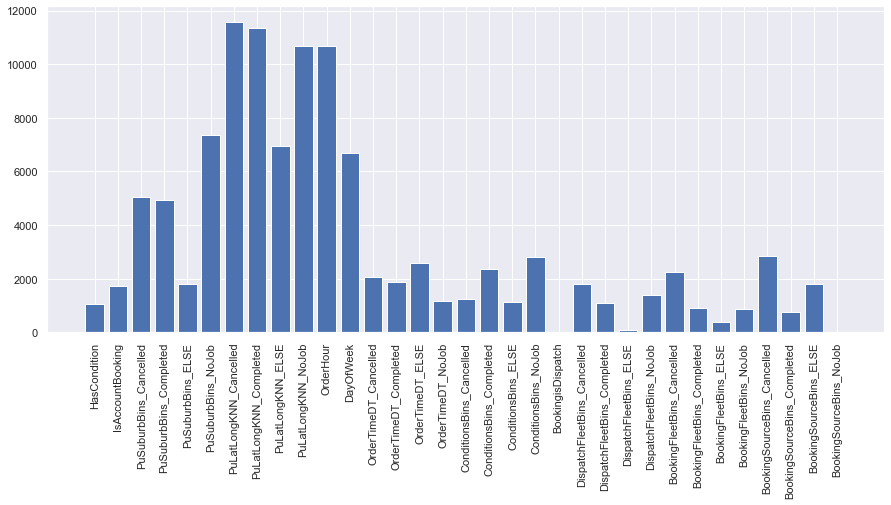

In [13]:
#extract feature importance
plt.figure(figsize=(15,6))
plt.bar(train[mdl_cols].columns.tolist(),lbst.feature_importances_)
plt.xticks(rotation=90)
lbst.feature_importances_.round(3)

In [ ]:
pd.DataFrame(lbst.feature_importances_.T,train[mdl_cols].columns).sort_values(0, ascending = False)
#print out feature importance